In [7]:
import wave
import json
import librosa
import csv
import numpy as np
from pywt import wavedec
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [9]:
import wave
import json

def reset_csv():
  header = 'filename'
  for i in range(1, 41):
      header += f' mfcc{i}'
  for i in range(1, 13):
    header += f' chroma{i}'
  for i in range(1, 61):
    header += f' cqt{i}'
  header += ' label'
  header = header.split()
  file = open('testing.csv', 'w', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(header)

In [10]:
def getModelArray(model_name):
  model_path = '../modelh5/'+model_name+'/best_model/'
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(model_path)):
    filenames.sort()
    filenames = filenames[10:] + filenames[:10]
    # cut each 10 array
    filenames = [filenames[i:i + 10] for i in range(0, len(filenames), 10)]
    return filenames[0], filenames[1], filenames[2], filenames[3], filenames[4], filenames[5], filenames[6], filenames[7], filenames[8], filenames[9]

def getPathModel(model_name):
  a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getModelArray(model_name)
  # switch index 2 to 10
  hasil = []
  for i in [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]:
    a = i[1]
    i.pop(1)
    i.append(a)
    for j in range(len(i)):
      i[j] = '../modelh5/'+model_name + '/best_model/' + i[j]
  return a1, a2, a3, a4, a5, a6, a7, a8, a9, a10

In [11]:
def testingVHD(array, db):
    index_db = 0
    accuracy_all = []
    precision_all = []
    sensitivity_all = []
    specificity_all = []
    f1_score_all = []

    for model_path in array:
        print("=======================================================")
        print("Processing "+ model_path)
        print("=======================================================")
        dataset_path = '../../data/testing_10/'
        reset_csv()

        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
                # ensure we're processing a genre sub-folder level
                if dirpath is not dataset_path:
                    semantic_label = dirpath.split("/")[-1]
                    for f in filenames:
                        file_path = os.path.join(dirpath, f)
                        to_append = f'{file_path}'
                        # print(file_path)
                        y, sr = librosa.load(file_path, mono=True, duration=3, sr=8000)
                        coeffs = wavedec(y, f'db{db}', level=10)
                        cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
                        list_cd = [cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8, cD9, cD10]
                        mfcc = librosa.feature.mfcc(y=list_cd[index_db], sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
                        rms = librosa.feature.chroma_stft(y=list_cd[index_db], sr=8000)
                        cqt = np.abs(librosa.cqt(y=list_cd[index_db], sr=sr, n_bins=60))
                        combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
                        to_append = f'{file_path}'
                        for e in combined_features:
                            to_append += f' {np.mean(e.T, axis=0)}'
                        to_append += f' {semantic_label}'
                        file = open('testing.csv', 'a', newline='')
                        with file:
                            writer = csv.writer(file)
                            writer.writerow(to_append.split())
        index_db += 1
        data = pd.read_csv('./testing.csv')
        
        lb = LabelEncoder()
        X = np.expand_dims(data.drop(['label', 'filename'], axis=1), axis=2)
        y = np.expand_dims(data.iloc[:, -1], axis=1)


        model = tf.keras.models.load_model(model_path)
        pred = model.predict(X)
        hasil = []
        class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
        # class_labels = ['MVP', 'MS', 'N', 'MR', 'AS']
        for predic in pred:
            cek = np.argmax(predic)
            hasil.append(class_labels[cek])
        # y_p = np.argmax(pred, axis=1)

        cm = confusion_matrix(y, hasil)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MR', 'MS', 'MVP', 'N'])
        disp.plot()
        plt.show()

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        print("Accuracy :" , ACC, 'mean: ', np.mean(ACC))
        print("Precision :" , PPV, 'mean: ', np.mean(PPV))
        print("Sensitivity :" , TPR, 'mean: ', np.mean(TPR))
        print("Specificity :" , TNR, 'mean: ', np.mean(TNR))
        print("f1_score:", 2 * (PPV * TPR) / (PPV + TPR), 'mean: ', np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        accuracy_all.append(np.mean(ACC))
        precision_all.append(np.mean(PPV))
        sensitivity_all.append(np.mean(TPR))
        specificity_all.append(np.mean(TNR))
        f1_score_all.append(np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        print("\n\n")

    print("=======================================================")
    print("Accuracy All :" , accuracy_all)
    print("Precision All :" , precision_all)
    print("Sensitivity All :" , sensitivity_all)
    print("Specificity All :" , specificity_all)
    print("f1_score All :", f1_score_all)
    print("=======================================================")




In [12]:
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getPathModel("RNN_FT")

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L1.csv_3.h5


4/4 [==============================] - 0s 5ms/step


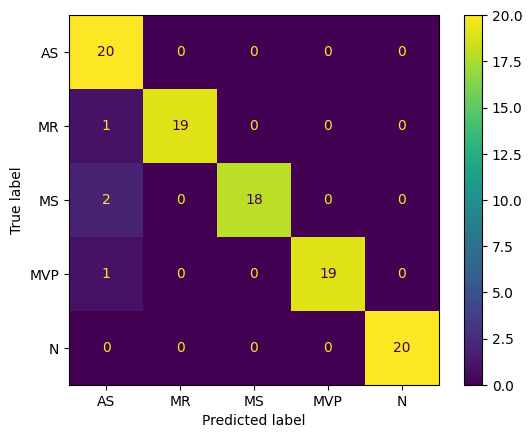

Accuracy : [0.96 0.99 0.98 0.99 1.  ] mean:  0.984
Precision : [0.83333333 1.         1.         1.         1.        ] mean:  0.9666666666666668
Sensitivity : [1.   0.95 0.9  0.95 1.  ] mean:  0.96
Specificity : [0.95 1.   1.   1.   1.  ] mean:  0.99
f1_score: [0.90909091 0.97435897 0.94736842 0.97435897 1.        ] mean:  0.9610354557722978



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L2.csv_2.h5
4/4 [==============================] - 0s 4ms/step


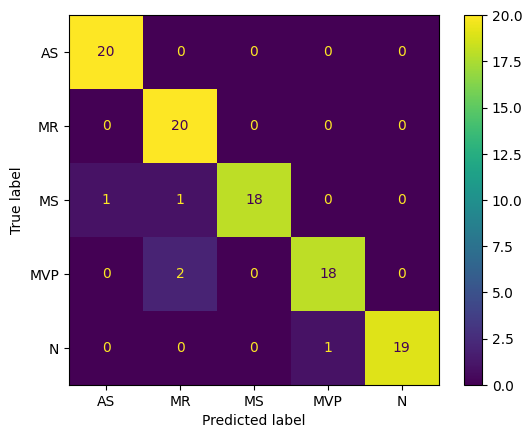

Accuracy : [0.99 0.97 0.98 0.97 0.99] mean:  0.9800000000000001
Precision : [0.95238095 0.86956522 1.         0.94736842 1.        ] mean:  0.9538629181649776
Sensitivity : [1.   1.   0.9  0.9  0.95] mean:  0.95
Specificity : [0.9875 0.9625 1.     0.9875 1.    ] mean:  0.9875
f1_score: [0.97560976 0.93023256 0.94736842 0.92307692 0.97435897] mean:  0.950129326545125



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L3.csv_2.h5
4/4 [==============================] - 0s 5ms/step


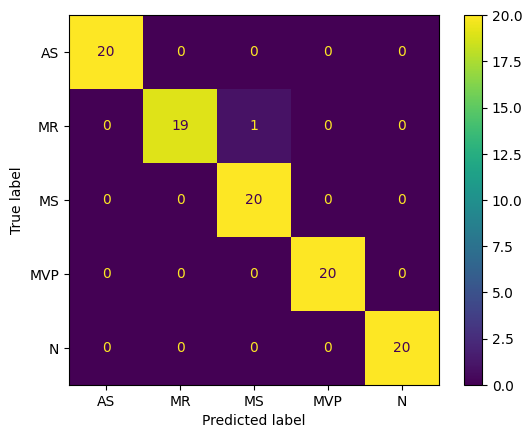

Accuracy : [1.   0.99 0.99 1.   1.  ] mean:  0.9960000000000001
Precision : [1.         1.         0.95238095 1.         1.        ] mean:  0.9904761904761905
Sensitivity : [1.   0.95 1.   1.   1.  ] mean:  0.99
Specificity : [1.     1.     0.9875 1.     1.    ] mean:  0.9974999999999999
f1_score: [1.         0.97435897 0.97560976 1.         1.        ] mean:  0.9899937460913071



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L4.csv_2.h5
4/4 [==============================] - 0s 4ms/step


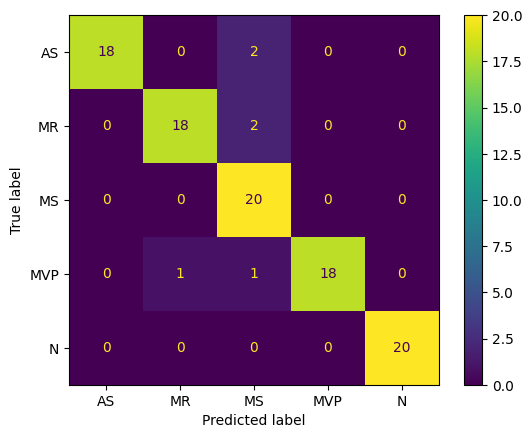

Accuracy : [0.98 0.97 0.95 0.98 1.  ] mean:  0.976
Precision : [1.         0.94736842 0.8        1.         1.        ] mean:  0.9494736842105264
Sensitivity : [0.9 0.9 1.  0.9 1. ] mean:  0.9399999999999998
Specificity : [1.     0.9875 0.9375 1.     1.    ] mean:  0.985
f1_score: [0.94736842 0.92307692 0.88888889 0.94736842 1.        ] mean:  0.9413405308142151



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L5.csv_3.h5
4/4 [==============================] - 0s 5ms/step


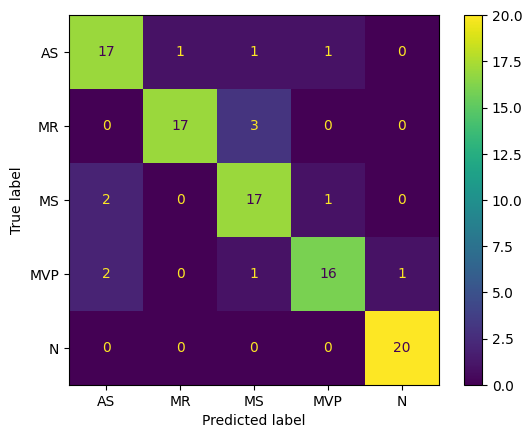

Accuracy : [0.93 0.96 0.92 0.94 0.99] mean:  0.9480000000000001
Precision : [0.80952381 0.94444444 0.77272727 0.88888889 0.95238095] mean:  0.8735930735930735
Sensitivity : [0.85 0.85 0.85 0.8  1.  ] mean:  0.8699999999999999
Specificity : [0.95   0.9875 0.9375 0.975  0.9875] mean:  0.9675
f1_score: [0.82926829 0.89473684 0.80952381 0.84210526 0.97560976] mean:  0.8702487927134911



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L6.csv_5.h5
4/4 [==============================] - 0s 6ms/step


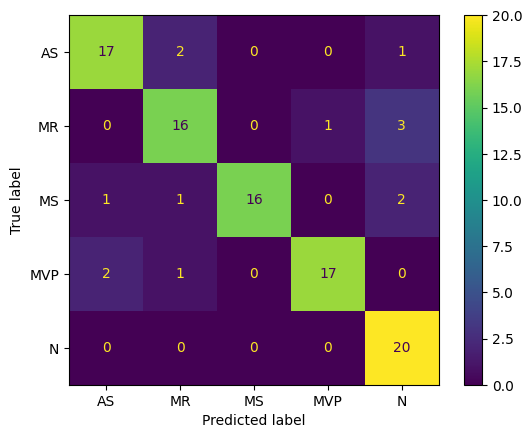

Accuracy : [0.94 0.92 0.96 0.96 0.94] mean:  0.944
Precision : [0.85       0.8        1.         0.94444444 0.76923077] mean:  0.8727350427350427
Sensitivity : [0.85 0.8  0.8  0.85 1.  ] mean:  0.8600000000000001
Specificity : [0.9625 0.95   1.     0.9875 0.925 ] mean:  0.9650000000000001
f1_score: [0.85       0.8        0.88888889 0.89473684 0.86956522] mean:  0.8606381896770914



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L7.csv_5.h5
4/4 [==============================] - 0s 4ms/step


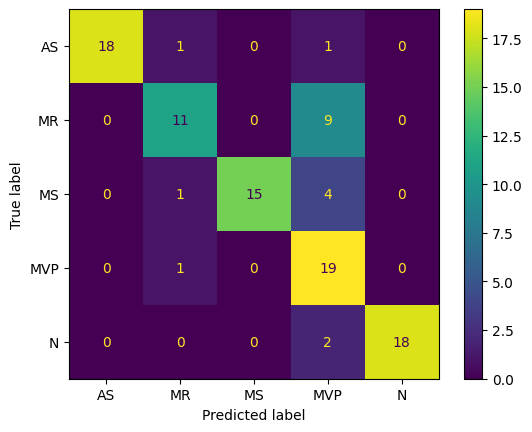

Accuracy : [0.98 0.88 0.95 0.83 0.98] mean:  0.9239999999999998
Precision : [1.         0.78571429 1.         0.54285714 1.        ] mean:  0.8657142857142857
Sensitivity : [0.9  0.55 0.75 0.95 0.9 ] mean:  0.8100000000000002
Specificity : [1.     0.9625 1.     0.8    1.    ] mean:  0.9525
f1_score: [0.94736842 0.64705882 0.85714286 0.69090909 0.94736842] mean:  0.8179695227373246



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L8.csv_4.h5
4/4 [==============================] - 0s 5ms/step


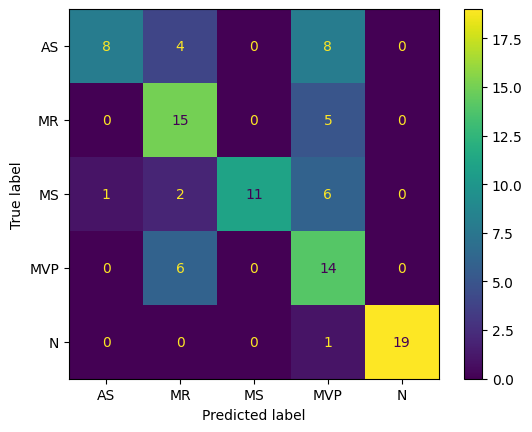

Accuracy : [0.87 0.83 0.91 0.74 0.99] mean:  0.868
Precision : [0.88888889 0.55555556 1.         0.41176471 1.        ] mean:  0.7712418300653595
Sensitivity : [0.4  0.75 0.55 0.7  0.95] mean:  0.6699999999999999
Specificity : [0.9875 0.85   1.     0.75   1.    ] mean:  0.9175000000000001
f1_score: [0.55172414 0.63829787 0.70967742 0.51851852 0.97435897] mean:  0.6785153845007583



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L9.csv_4.h5
4/4 [==============================] - 0s 6ms/step


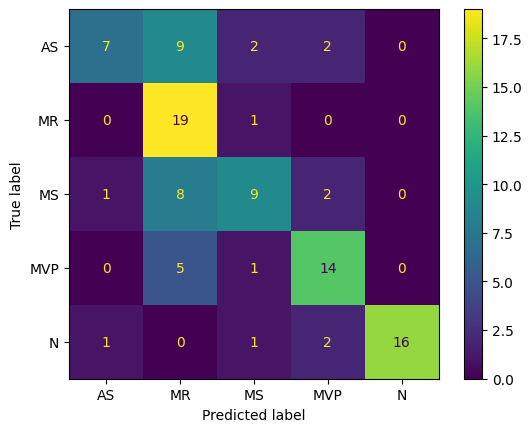

Accuracy : [0.85 0.77 0.84 0.88 0.96] mean:  0.86
Precision : [0.77777778 0.46341463 0.64285714 0.7        1.        ] mean:  0.7168099109562525
Sensitivity : [0.35 0.95 0.45 0.7  0.8 ] mean:  0.65
Specificity : [0.975  0.725  0.9375 0.925  1.    ] mean:  0.9125
f1_score: [0.48275862 0.62295082 0.52941176 0.7        0.88888889] mean:  0.6448020187913115



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb1L10.csv_5.h5
4/4 [==============================] - 0s 4ms/step


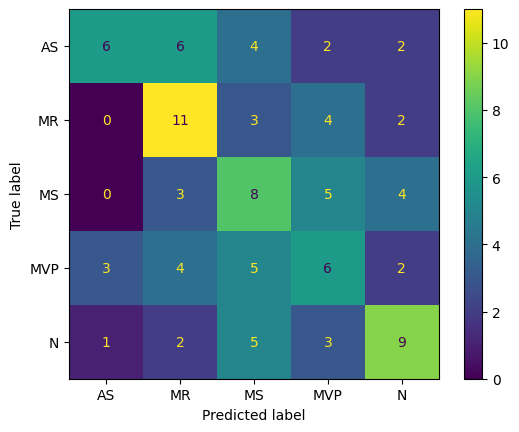

Accuracy : [0.82 0.76 0.71 0.72 0.79] mean:  0.76
Precision : [0.6        0.42307692 0.32       0.3        0.47368421] mean:  0.4233522267206478
Sensitivity : [0.3  0.55 0.4  0.3  0.45] mean:  0.4
Specificity : [0.95   0.8125 0.7875 0.825  0.875 ] mean:  0.85
f1_score: [0.4        0.47826087 0.35555556 0.3        0.46153846] mean:  0.39907097733184693



Accuracy All : [0.984, 0.9800000000000001, 0.9960000000000001, 0.976, 0.9480000000000001, 0.944, 0.9239999999999998, 0.868, 0.86, 0.76]
Precision All : [0.9666666666666668, 0.9538629181649776, 0.9904761904761905, 0.9494736842105264, 0.8735930735930735, 0.8727350427350427, 0.8657142857142857, 0.7712418300653595, 0.7168099109562525, 0.4233522267206478]
Sensitivity All : [0.96, 0.95, 0.99, 0.9399999999999998, 0.8699999999999999, 0.8600000000000001, 0.8100000000000002, 0.6699999999999999, 0.65, 0.4]
Specificity All : [0.99, 0.9875, 0.9974999999999999, 0.985, 0.9675, 0.9650000000000001, 0.9525, 0.9175000000000001, 0.9125, 0.85]
f1_score All

In [13]:
testingVHD(a1, 1)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L1.csv_5.h5


4/4 [==============================] - 0s 6ms/step


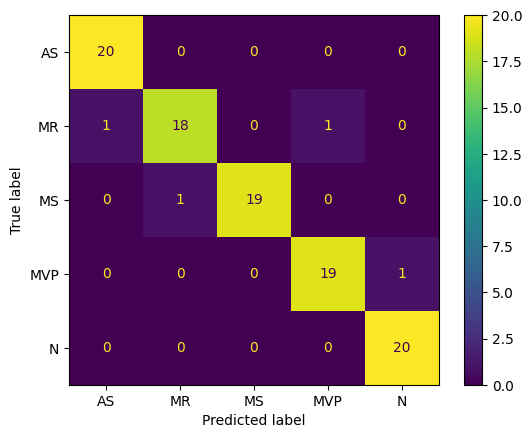

Accuracy : [0.99 0.97 0.99 0.98 0.99] mean:  0.984
Precision : [0.95238095 0.94736842 1.         0.95       0.95238095] mean:  0.9604260651629073
Sensitivity : [1.   0.9  0.95 0.95 1.  ] mean:  0.96
Specificity : [0.9875 0.9875 1.     0.9875 0.9875] mean:  0.99
f1_score: [0.97560976 0.92307692 0.97435897 0.95       0.97560976] mean:  0.9597310819262038



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L2.csv_2.h5
4/4 [==============================] - 0s 5ms/step


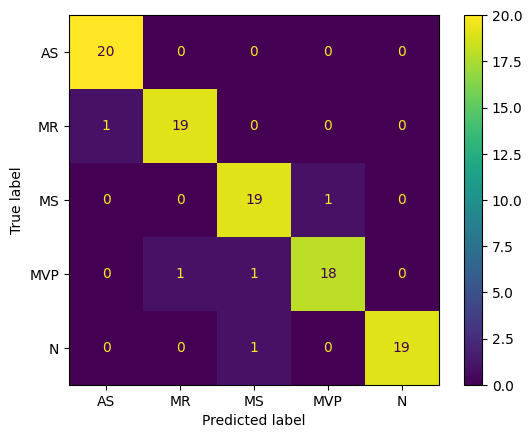

Accuracy : [0.99 0.98 0.97 0.97 0.99] mean:  0.9800000000000001
Precision : [0.95238095 0.95       0.9047619  0.94736842 1.        ] mean:  0.9509022556390978
Sensitivity : [1.   0.95 0.95 0.9  0.95] mean:  0.95
Specificity : [0.9875 0.9875 0.975  0.9875 1.    ] mean:  0.9875
f1_score: [0.97560976 0.95       0.92682927 0.92307692 0.97435897] mean:  0.9499749843652283



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L3.csv_2.h5
4/4 [==============================] - 0s 4ms/step


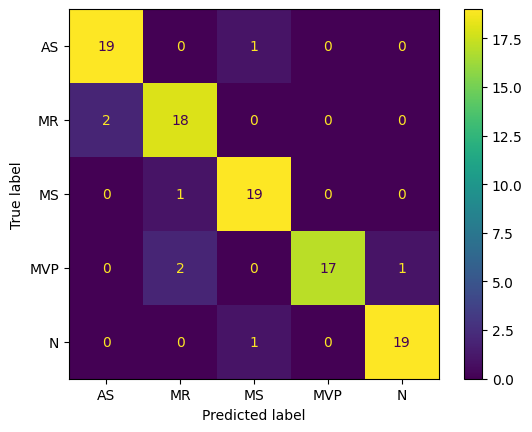

Accuracy : [0.97 0.95 0.97 0.97 0.98] mean:  0.968
Precision : [0.9047619  0.85714286 0.9047619  1.         0.95      ] mean:  0.9233333333333332
Sensitivity : [0.95 0.9  0.95 0.85 0.95] mean:  0.9199999999999999
Specificity : [0.975  0.9625 0.975  1.     0.9875] mean:  0.9800000000000001
f1_score: [0.92682927 0.87804878 0.92682927 0.91891892 0.95      ] mean:  0.9201252471984178



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L4.csv_5.h5
4/4 [==============================] - 0s 5ms/step


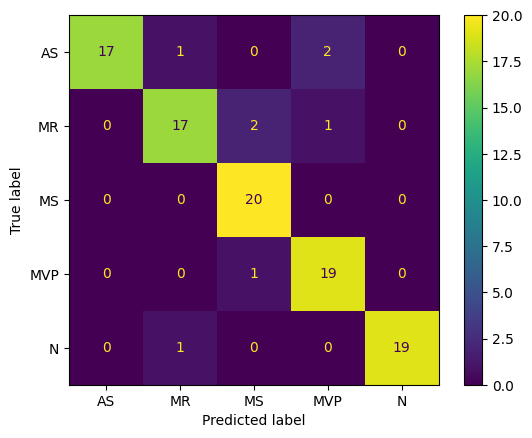

Accuracy : [0.97 0.95 0.97 0.96 0.99] mean:  0.968
Precision : [1.         0.89473684 0.86956522 0.86363636 1.        ] mean:  0.9255876846265864
Sensitivity : [0.85 0.85 1.   0.95 0.95] mean:  0.9200000000000002
Specificity : [1.     0.975  0.9625 0.9625 1.    ] mean:  0.9800000000000001
f1_score: [0.91891892 0.87179487 0.93023256 0.9047619  0.97435897] mean:  0.9200134455948408



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


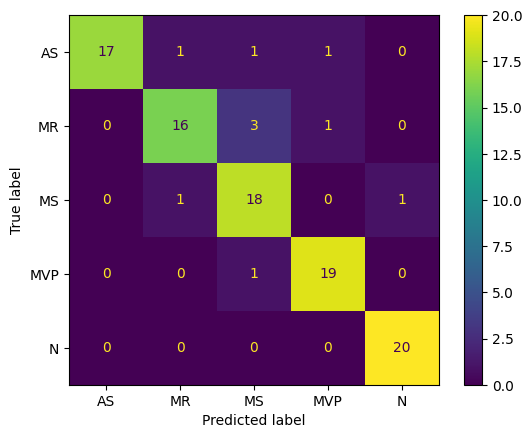

Accuracy : [0.97 0.94 0.93 0.97 0.99] mean:  0.96
Precision : [1.         0.88888889 0.7826087  0.9047619  0.95238095] mean:  0.905728088336784
Sensitivity : [0.85 0.8  0.9  0.95 1.  ] mean:  0.9
Specificity : [1.     0.975  0.9375 0.975  0.9875] mean:  0.975
f1_score: [0.91891892 0.84210526 0.8372093  0.92682927 0.97560976] mean:  0.9001345017585278



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L6.csv_2.h5
4/4 [==============================] - 0s 5ms/step


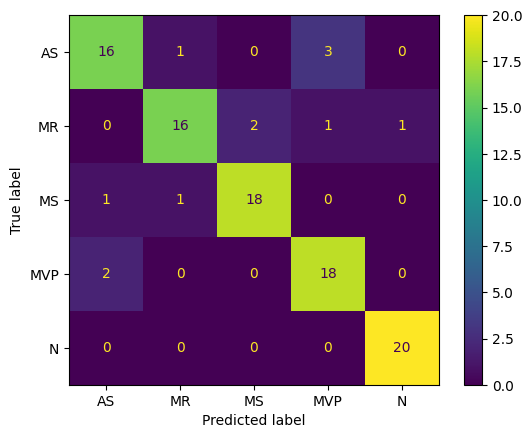

Accuracy : [0.93 0.94 0.96 0.94 0.99] mean:  0.952
Precision : [0.84210526 0.88888889 0.9        0.81818182 0.95238095] mean:  0.8803113845219108
Sensitivity : [0.8 0.8 0.9 0.9 1. ] mean:  0.8800000000000001
Specificity : [0.9625 0.975  0.975  0.95   0.9875] mean:  0.97
f1_score: [0.82051282 0.84210526 0.9        0.85714286 0.97560976] mean:  0.8790741393822266



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L7.csv_2.h5
4/4 [==============================] - 0s 4ms/step


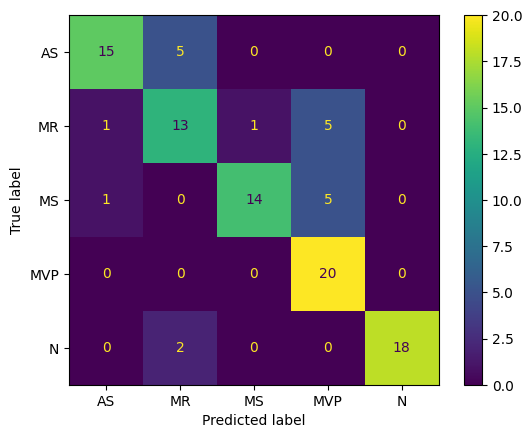

Accuracy : [0.93 0.86 0.93 0.9  0.98] mean:  0.9199999999999999
Precision : [0.88235294 0.65       0.93333333 0.66666667 1.        ] mean:  0.8264705882352942
Sensitivity : [0.75 0.65 0.7  1.   0.9 ] mean:  0.7999999999999999
Specificity : [0.975  0.9125 0.9875 0.875  1.    ] mean:  0.95
f1_score: [0.81081081 0.65       0.8        0.8        0.94736842] mean:  0.8016358463726885



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L8.csv_5.h5
4/4 [==============================] - 0s 4ms/step


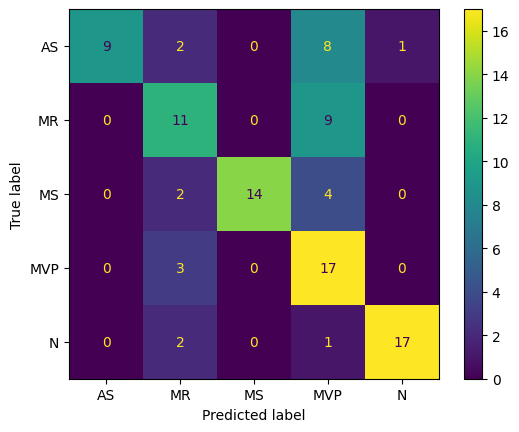

Accuracy : [0.89 0.82 0.94 0.75 0.96] mean:  0.8719999999999999
Precision : [1.         0.55       1.         0.43589744 0.94444444] mean:  0.7860683760683761
Sensitivity : [0.45 0.55 0.7  0.85 0.85] mean:  0.6799999999999999
Specificity : [1.     0.8875 1.     0.725  0.9875] mean:  0.9200000000000002
f1_score: [0.62068966 0.55       0.82352941 0.57627119 0.89473684] mean:  0.6930454190966122



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L9.csv_4.h5
4/4 [==============================] - 0s 5ms/step


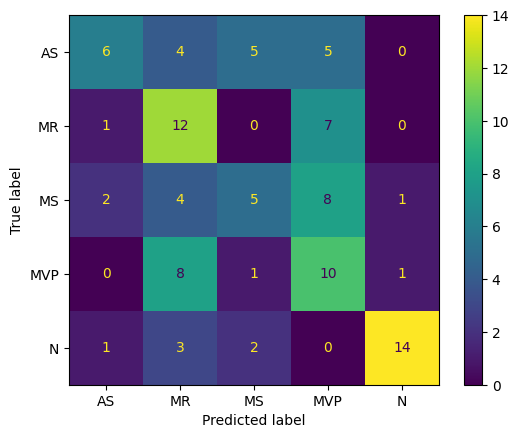

Accuracy : [0.82 0.73 0.77 0.7  0.92] mean:  0.7879999999999999
Precision : [0.6        0.38709677 0.38461538 0.33333333 0.875     ] mean:  0.5160090984284532
Sensitivity : [0.3  0.6  0.25 0.5  0.7 ] mean:  0.4699999999999999
Specificity : [0.95   0.7625 0.9    0.75   0.975 ] mean:  0.8674999999999999
f1_score: [0.4        0.47058824 0.3030303  0.4        0.77777778] mean:  0.47027926322043967



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb2L10.csv_1.h5
4/4 [==============================] - 0s 4ms/step


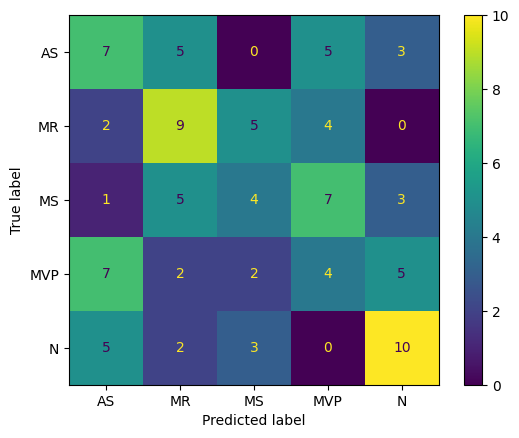

Accuracy : [0.72 0.75 0.74 0.68 0.79] mean:  0.736
Precision : [0.31818182 0.39130435 0.28571429 0.2        0.47619048] mean:  0.33427818558253336
Sensitivity : [0.35 0.45 0.2  0.2  0.5 ] mean:  0.33999999999999997
Specificity : [0.8125 0.825  0.875  0.8    0.8625] mean:  0.835
f1_score: [0.33333333 0.41860465 0.23529412 0.2        0.48780488] mean:  0.3350073960383927



Accuracy All : [0.984, 0.9800000000000001, 0.968, 0.968, 0.96, 0.952, 0.9199999999999999, 0.8719999999999999, 0.7879999999999999, 0.736]
Precision All : [0.9604260651629073, 0.9509022556390978, 0.9233333333333332, 0.9255876846265864, 0.905728088336784, 0.8803113845219108, 0.8264705882352942, 0.7860683760683761, 0.5160090984284532, 0.33427818558253336]
Sensitivity All : [0.96, 0.95, 0.9199999999999999, 0.9200000000000002, 0.9, 0.8800000000000001, 0.7999999999999999, 0.6799999999999999, 0.4699999999999999, 0.33999999999999997]
Specificity All : [0.99, 0.9875, 0.9800000000000001, 0.9800000000000001, 0.975, 0.97, 0.95, 0.

In [14]:
testingVHD(a2, 2)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L1.csv_3.h5


4/4 [==============================] - 0s 5ms/step


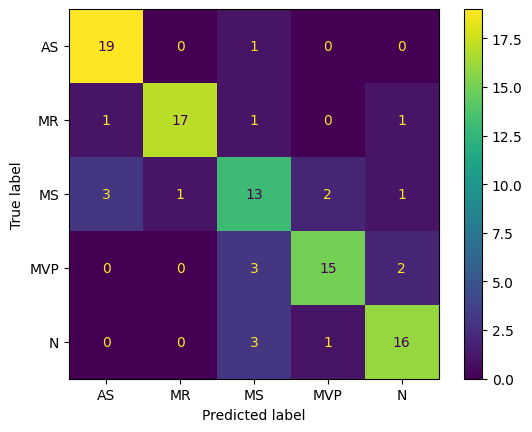

Accuracy : [0.95 0.96 0.85 0.92 0.92] mean:  0.9199999999999999
Precision : [0.82608696 0.94444444 0.61904762 0.83333333 0.8       ] mean:  0.8045824706694272
Sensitivity : [0.95 0.85 0.65 0.75 0.8 ] mean:  0.8
Specificity : [0.95   0.9875 0.9    0.9625 0.95  ] mean:  0.95
f1_score: [0.88372093 0.89473684 0.63414634 0.78947368 0.8       ] mean:  0.8004155596023524



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L2.csv_2.h5
4/4 [==============================] - 0s 5ms/step


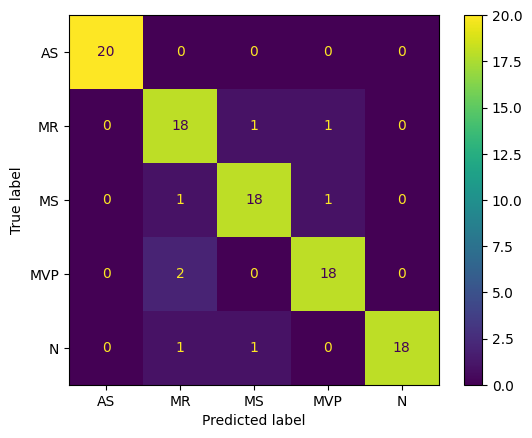

Accuracy : [1.   0.94 0.96 0.96 0.98] mean:  0.968
Precision : [1.         0.81818182 0.9        0.9        1.        ] mean:  0.9236363636363636
Sensitivity : [1.  0.9 0.9 0.9 0.9] mean:  0.9199999999999999
Specificity : [1.    0.95  0.975 0.975 1.   ] mean:  0.9800000000000001
f1_score: [1.         0.85714286 0.9        0.9        0.94736842] mean:  0.9209022556390977



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L3.csv_2.h5
4/4 [==============================] - 0s 4ms/step


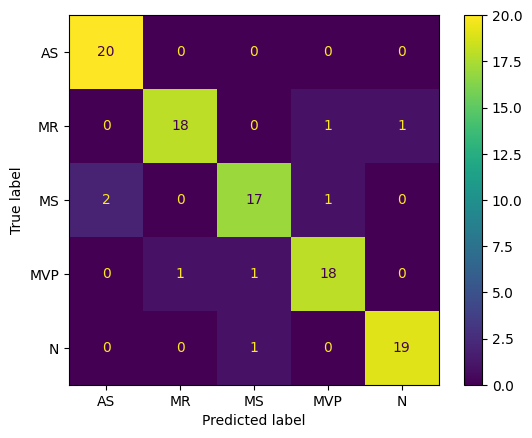

Accuracy : [0.98 0.97 0.95 0.96 0.98] mean:  0.968
Precision : [0.90909091 0.94736842 0.89473684 0.9        0.95      ] mean:  0.9202392344497607
Sensitivity : [1.   0.9  0.85 0.9  0.95] mean:  0.9199999999999999
Specificity : [0.975  0.9875 0.975  0.975  0.9875] mean:  0.9800000000000001
f1_score: [0.95238095 0.92307692 0.87179487 0.9        0.95      ] mean:  0.9194505494505494



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L4.csv_5.h5
4/4 [==============================] - 0s 5ms/step


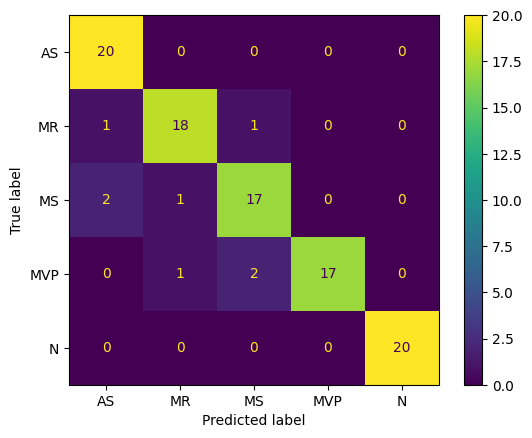

Accuracy : [0.97 0.96 0.94 0.97 1.  ] mean:  0.968
Precision : [0.86956522 0.9        0.85       1.         1.        ] mean:  0.923913043478261
Sensitivity : [1.   0.9  0.85 0.85 1.  ] mean:  0.9199999999999999
Specificity : [0.9625 0.975  0.9625 1.     1.    ] mean:  0.9800000000000001
f1_score: [0.93023256 0.9        0.85       0.91891892 1.        ] mean:  0.9198302954116908



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L5.csv_2.h5
4/4 [==============================] - 0s 4ms/step


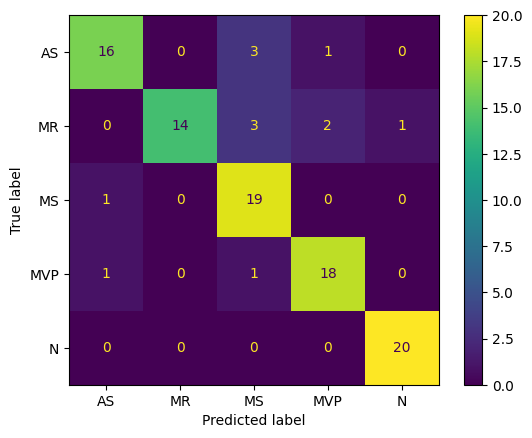

Accuracy : [0.94 0.94 0.92 0.95 0.99] mean:  0.9480000000000001
Precision : [0.88888889 1.         0.73076923 0.85714286 0.95238095] mean:  0.8858363858363859
Sensitivity : [0.8  0.7  0.95 0.9  1.  ] mean:  0.8699999999999999
Specificity : [0.975  1.     0.9125 0.9625 0.9875] mean:  0.9675
f1_score: [0.84210526 0.82352941 0.82608696 0.87804878 0.97560976] mean:  0.8690760336059412



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L6.csv_5.h5
4/4 [==============================] - 0s 5ms/step


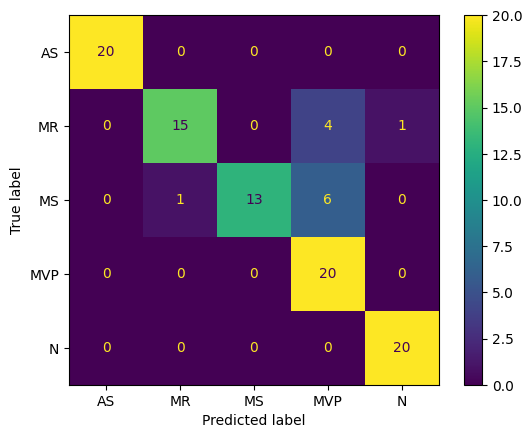

Accuracy : [1.   0.94 0.93 0.9  0.99] mean:  0.952
Precision : [1.         0.9375     1.         0.66666667 0.95238095] mean:  0.9113095238095237
Sensitivity : [1.   0.75 0.65 1.   1.  ] mean:  0.8800000000000001
Specificity : [1.     0.9875 1.     0.875  0.9875] mean:  0.97
f1_score: [1.         0.83333333 0.78787879 0.8        0.97560976] mean:  0.8793643754619366



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L7.csv_4.h5
4/4 [==============================] - 0s 5ms/step


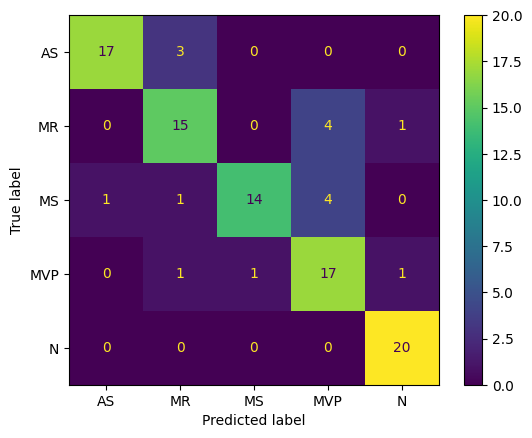

Accuracy : [0.96 0.9  0.93 0.89 0.98] mean:  0.932
Precision : [0.94444444 0.75       0.93333333 0.68       0.90909091] mean:  0.8433737373737374
Sensitivity : [0.85 0.75 0.7  0.85 1.  ] mean:  0.8300000000000001
Specificity : [0.9875 0.9375 0.9875 0.9    0.975 ] mean:  0.9574999999999999
f1_score: [0.89473684 0.75       0.8        0.75555556 0.95238095] mean:  0.8305346700083543



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L8.csv_5.h5
4/4 [==============================] - 0s 5ms/step


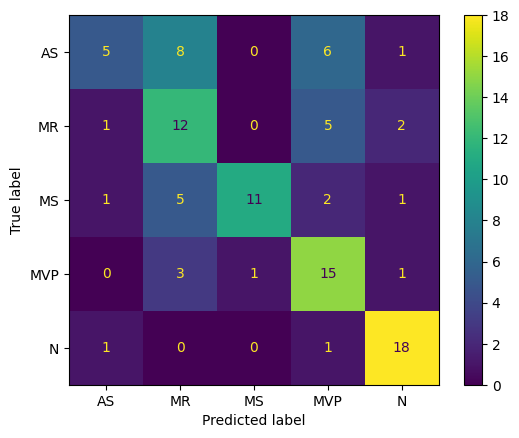

Accuracy : [0.82 0.76 0.9  0.81 0.93] mean:  0.844
Precision : [0.625      0.42857143 0.91666667 0.51724138 0.7826087 ] mean:  0.6540176340401228
Sensitivity : [0.25 0.6  0.55 0.75 0.9 ] mean:  0.61
Specificity : [0.9625 0.8    0.9875 0.825  0.9375] mean:  0.9025000000000001
f1_score: [0.35714286 0.5        0.6875     0.6122449  0.8372093 ] mean:  0.5988194114855245



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L9.csv_3.h5
4/4 [==============================] - 0s 5ms/step


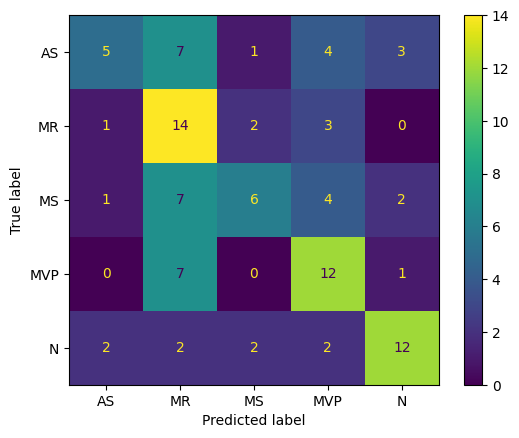

Accuracy : [0.81 0.71 0.81 0.79 0.86] mean:  0.796
Precision : [0.55555556 0.37837838 0.54545455 0.48       0.66666667] mean:  0.5252110292110291
Sensitivity : [0.25 0.7  0.3  0.6  0.6 ] mean:  0.49000000000000005
Specificity : [0.95   0.7125 0.9375 0.8375 0.925 ] mean:  0.8724999999999999
f1_score: [0.34482759 0.49122807 0.38709677 0.53333333 0.63157895] mean:  0.47761294225552753



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb3L10.csv_2.h5
4/4 [==============================] - 0s 4ms/step


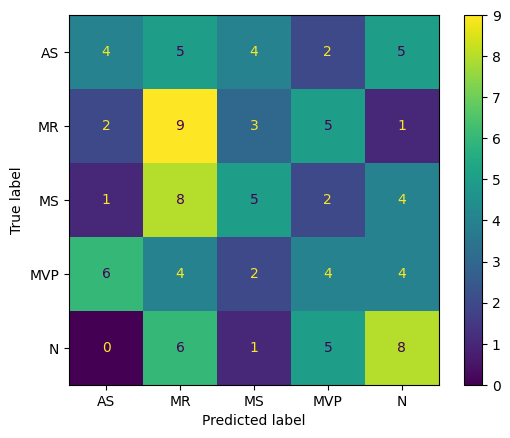

Accuracy : [0.75 0.66 0.75 0.7  0.74] mean:  0.7200000000000001
Precision : [0.30769231 0.28125    0.33333333 0.22222222 0.36363636] mean:  0.3016268453768454
Sensitivity : [0.2  0.45 0.25 0.2  0.4 ] mean:  0.3
Specificity : [0.8875 0.7125 0.875  0.825  0.825 ] mean:  0.825
f1_score: [0.24242424 0.34615385 0.28571429 0.21052632 0.38095238] mean:  0.2931542142068458



Accuracy All : [0.9199999999999999, 0.968, 0.968, 0.968, 0.9480000000000001, 0.952, 0.932, 0.844, 0.796, 0.7200000000000001]
Precision All : [0.8045824706694272, 0.9236363636363636, 0.9202392344497607, 0.923913043478261, 0.8858363858363859, 0.9113095238095237, 0.8433737373737374, 0.6540176340401228, 0.5252110292110291, 0.3016268453768454]
Sensitivity All : [0.8, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 0.8699999999999999, 0.8800000000000001, 0.8300000000000001, 0.61, 0.49000000000000005, 0.3]
Specificity All : [0.95, 0.9800000000000001, 0.9800000000000001, 0.9800000000000001, 0.9675, 0.97, 0.95749999999

In [15]:
testingVHD(a3, 3)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L1.csv_5.h5
4/4 [==============================] - 0s 5ms/step


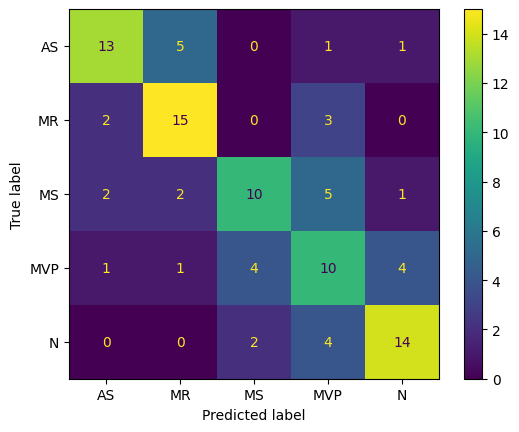

Accuracy : [0.88 0.87 0.84 0.77 0.88] mean:  0.8480000000000001
Precision : [0.72222222 0.65217391 0.625      0.43478261 0.7       ] mean:  0.6268357487922704
Sensitivity : [0.65 0.75 0.5  0.5  0.7 ] mean:  0.6199999999999999
Specificity : [0.9375 0.9    0.925  0.8375 0.925 ] mean:  0.905
f1_score: [0.68421053 0.69767442 0.55555556 0.46511628 0.7       ] mean:  0.6205113559091527



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L2.csv_5.h5
4/4 [==============================] - 0s 5ms/step


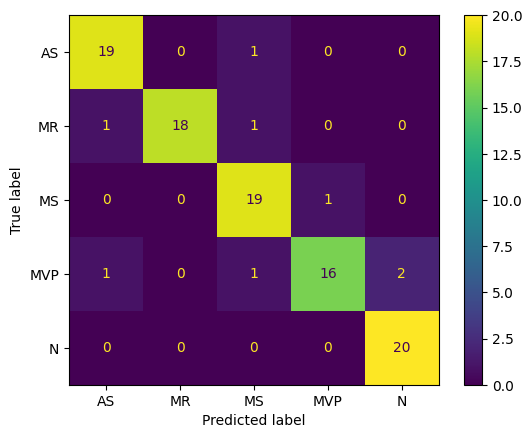

Accuracy : [0.97 0.98 0.96 0.95 0.98] mean:  0.968
Precision : [0.9047619  1.         0.86363636 0.94117647 0.90909091] mean:  0.9237331296154826
Sensitivity : [0.95 0.9  0.95 0.8  1.  ] mean:  0.9199999999999999
Specificity : [0.975  1.     0.9625 0.9875 0.975 ] mean:  0.9799999999999999
f1_score: [0.92682927 0.94736842 0.9047619  0.86486486 0.95238095] mean:  0.9192410822706073



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L3.csv_2.h5
4/4 [==============================] - 0s 4ms/step


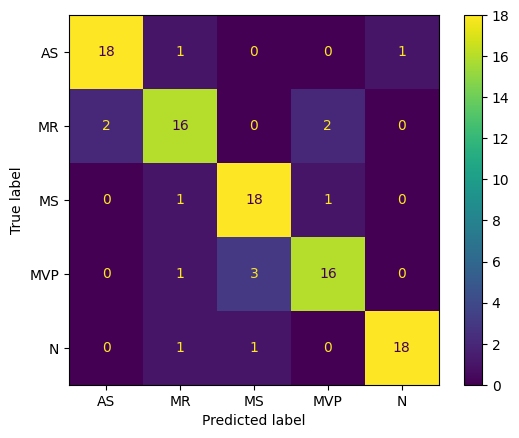

Accuracy : [0.96 0.92 0.94 0.93 0.97] mean:  0.944
Precision : [0.9        0.8        0.81818182 0.84210526 0.94736842] mean:  0.861531100478469
Sensitivity : [0.9 0.8 0.9 0.8 0.9] mean:  0.8600000000000001
Specificity : [0.975  0.95   0.95   0.9625 0.9875] mean:  0.9650000000000001
f1_score: [0.9        0.8        0.85714286 0.82051282 0.92307692] mean:  0.8601465201465203



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L4.csv_2.h5
4/4 [==============================] - 0s 4ms/step


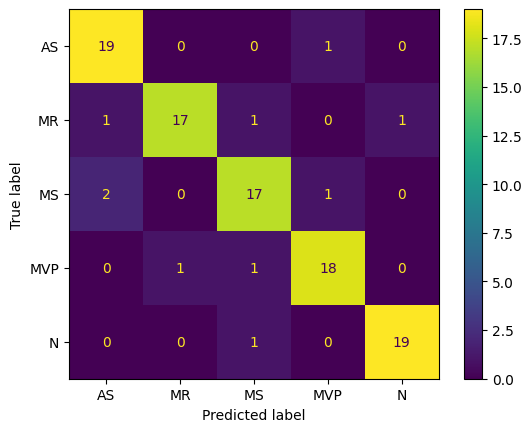

Accuracy : [0.96 0.96 0.94 0.96 0.98] mean:  0.96
Precision : [0.86363636 0.94444444 0.85       0.9        0.95      ] mean:  0.9016161616161616
Sensitivity : [0.95 0.85 0.85 0.9  0.95] mean:  0.9
Specificity : [0.9625 0.9875 0.9625 0.975  0.9875] mean:  0.975
f1_score: [0.9047619  0.89473684 0.85       0.9        0.95      ] mean:  0.8998997493734336



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L5.csv_2.h5
4/4 [==============================] - 0s 4ms/step


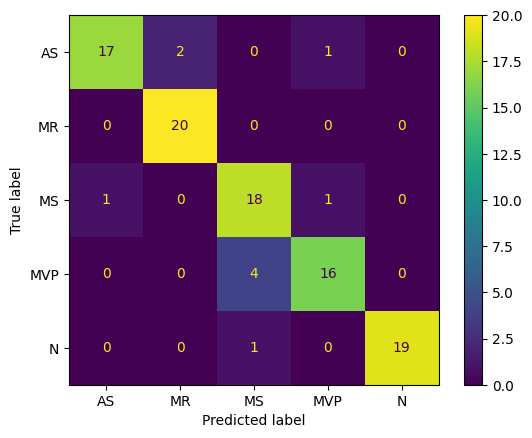

Accuracy : [0.96 0.98 0.93 0.94 0.99] mean:  0.96
Precision : [0.94444444 0.90909091 0.7826087  0.88888889 1.        ] mean:  0.9050065876152832
Sensitivity : [0.85 1.   0.9  0.8  0.95] mean:  0.9
Specificity : [0.9875 0.975  0.9375 0.975  1.    ] mean:  0.975
f1_score: [0.89473684 0.95238095 0.8372093  0.84210526 0.97435897] mean:  0.9001582668657331



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


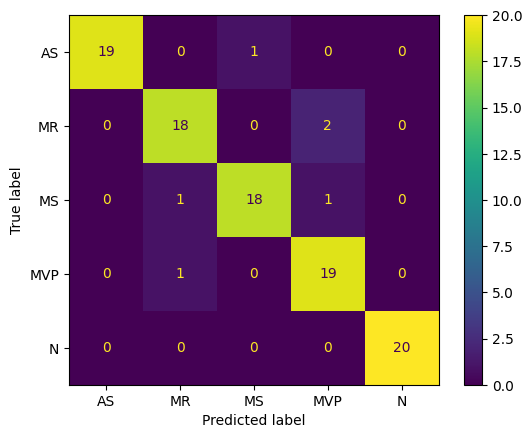

Accuracy : [0.99 0.96 0.97 0.96 1.  ] mean:  0.976
Precision : [1.         0.9        0.94736842 0.86363636 1.        ] mean:  0.9422009569377992
Sensitivity : [0.95 0.9  0.9  0.95 1.  ] mean:  0.9400000000000001
Specificity : [1.     0.975  0.9875 0.9625 1.    ] mean:  0.9850000000000001
f1_score: [0.97435897 0.9        0.92307692 0.9047619  1.        ] mean:  0.9404395604395603



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L7.csv_5.h5
4/4 [==============================] - 0s 5ms/step


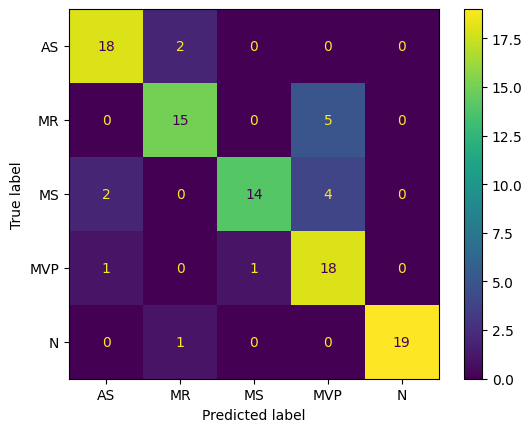

Accuracy : [0.95 0.92 0.93 0.89 0.99] mean:  0.9360000000000002
Precision : [0.85714286 0.83333333 0.93333333 0.66666667 1.        ] mean:  0.858095238095238
Sensitivity : [0.9  0.75 0.7  0.9  0.95] mean:  0.8399999999999999
Specificity : [0.9625 0.9625 0.9875 0.8875 1.    ] mean:  0.96
f1_score: [0.87804878 0.78947368 0.8        0.76595745 0.97435897] mean:  0.8415677771731632



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L8.csv_1.h5
4/4 [==============================] - 0s 4ms/step


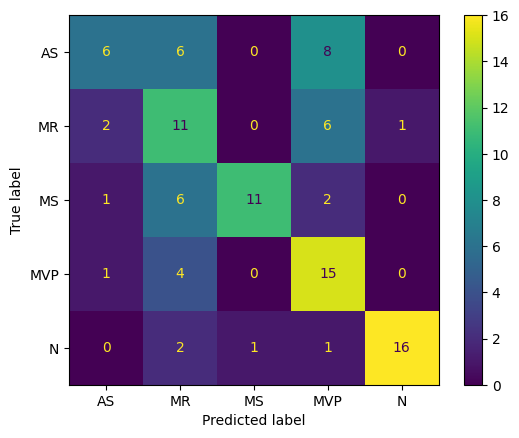

Accuracy : [0.82 0.73 0.9  0.78 0.95] mean:  0.836
Precision : [0.6        0.37931034 0.91666667 0.46875    0.94117647] mean:  0.6611806964164977
Sensitivity : [0.3  0.55 0.55 0.75 0.8 ] mean:  0.5900000000000001
Specificity : [0.95   0.775  0.9875 0.7875 0.9875] mean:  0.8975000000000002
f1_score: [0.4        0.44897959 0.6875     0.57692308 0.86486486] mean:  0.5956535067249353



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L9.csv_4.h5
4/4 [==============================] - 0s 4ms/step


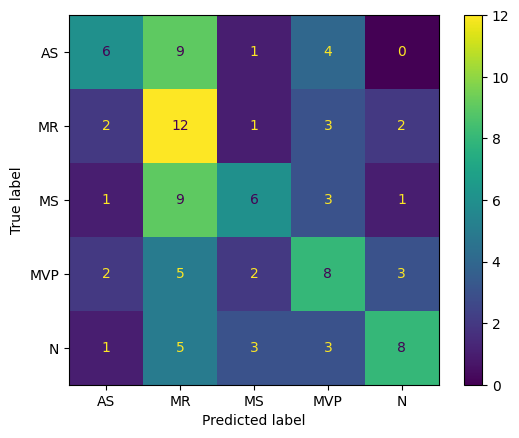

Accuracy : [0.8  0.64 0.79 0.75 0.82] mean:  0.76
Precision : [0.5        0.3        0.46153846 0.38095238 0.57142857] mean:  0.4427838827838828
Sensitivity : [0.3 0.6 0.3 0.4 0.4] mean:  0.4
Specificity : [0.925  0.65   0.9125 0.8375 0.925 ] mean:  0.85
f1_score: [0.375      0.4        0.36363636 0.3902439  0.47058824] mean:  0.39989370027390114



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb4L10.csv_1.h5
4/4 [==============================] - 0s 5ms/step


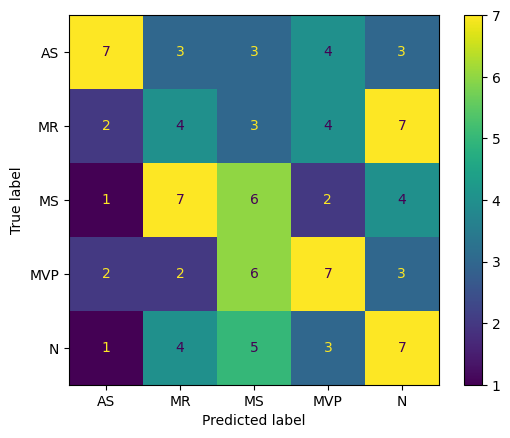

Accuracy : [0.81 0.68 0.69 0.74 0.7 ] mean:  0.724
Precision : [0.53846154 0.2        0.26086957 0.35       0.29166667] mean:  0.32819955406911927
Sensitivity : [0.35 0.2  0.3  0.35 0.35] mean:  0.31000000000000005
Specificity : [0.925  0.8    0.7875 0.8375 0.7875] mean:  0.8275
f1_score: [0.42424242 0.2        0.27906977 0.35       0.31818182] mean:  0.3142988019732206



Accuracy All : [0.8480000000000001, 0.968, 0.944, 0.96, 0.96, 0.976, 0.9360000000000002, 0.836, 0.76, 0.724]
Precision All : [0.6268357487922704, 0.9237331296154826, 0.861531100478469, 0.9016161616161616, 0.9050065876152832, 0.9422009569377992, 0.858095238095238, 0.6611806964164977, 0.4427838827838828, 0.32819955406911927]
Sensitivity All : [0.6199999999999999, 0.9199999999999999, 0.8600000000000001, 0.9, 0.9, 0.9400000000000001, 0.8399999999999999, 0.5900000000000001, 0.4, 0.31000000000000005]
Specificity All : [0.905, 0.9799999999999999, 0.9650000000000001, 0.975, 0.975, 0.9850000000000001, 0.96, 0.8975000000000002

In [16]:
testingVHD(a4, 4)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L1.csv_3.h5


4/4 [==============================] - 0s 4ms/step


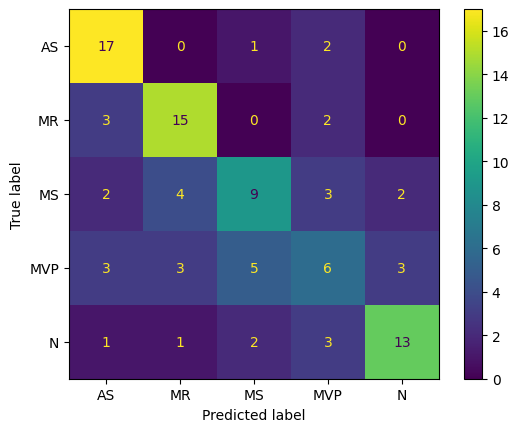

Accuracy : [0.88 0.87 0.81 0.76 0.88] mean:  0.8400000000000001
Precision : [0.65384615 0.65217391 0.52941176 0.375      0.72222222] mean:  0.5865308107635474
Sensitivity : [0.85 0.75 0.45 0.3  0.65] mean:  0.6
Specificity : [0.8875 0.9    0.9    0.875  0.9375] mean:  0.9
f1_score: [0.73913043 0.69767442 0.48648649 0.33333333 0.68421053] mean:  0.5881670399045739



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L2.csv_2.h5
4/4 [==============================] - 0s 5ms/step


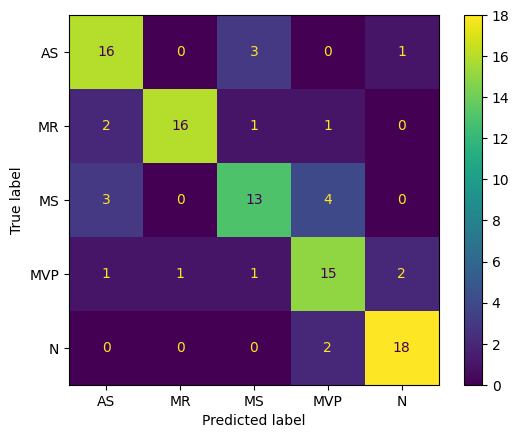

Accuracy : [0.9  0.95 0.88 0.88 0.95] mean:  0.9119999999999999
Precision : [0.72727273 0.94117647 0.72222222 0.68181818 0.85714286] mean:  0.7859264918088448
Sensitivity : [0.8  0.8  0.65 0.75 0.9 ] mean:  0.78
Specificity : [0.925  0.9875 0.9375 0.9125 0.9625] mean:  0.9450000000000001
f1_score: [0.76190476 0.86486486 0.68421053 0.71428571 0.87804878] mean:  0.7806629295717871



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L3.csv_2.h5
4/4 [==============================] - 0s 5ms/step


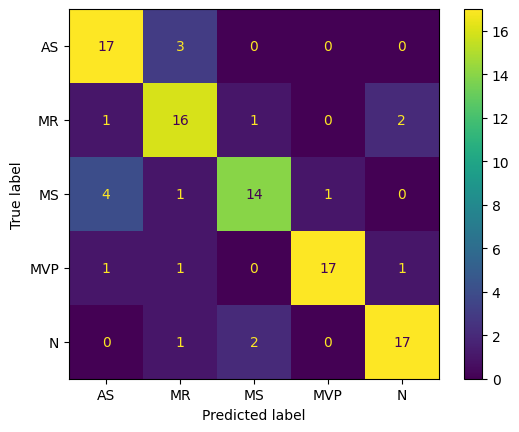

Accuracy : [0.91 0.9  0.91 0.96 0.94] mean:  0.924
Precision : [0.73913043 0.72727273 0.82352941 0.94444444 0.85      ] mean:  0.8168754036528971
Sensitivity : [0.85 0.8  0.7  0.85 0.85] mean:  0.8099999999999999
Specificity : [0.925  0.925  0.9625 0.9875 0.9625] mean:  0.9525
f1_score: [0.79069767 0.76190476 0.75675676 0.89473684 0.85      ] mean:  0.8108192070370773



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L4.csv_5.h5
4/4 [==============================] - 0s 4ms/step


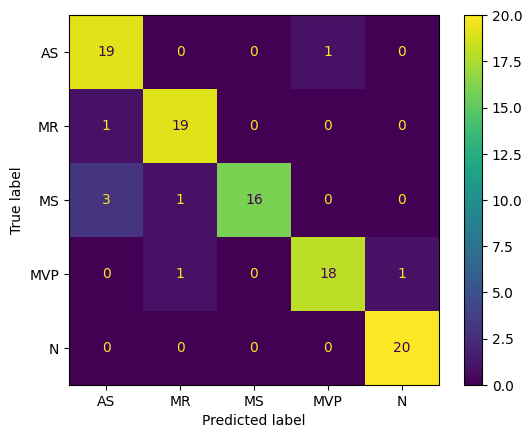

Accuracy : [0.95 0.97 0.96 0.97 0.99] mean:  0.968
Precision : [0.82608696 0.9047619  1.         0.94736842 0.95238095] mean:  0.9261196469434456
Sensitivity : [0.95 0.95 0.8  0.9  1.  ] mean:  0.9199999999999999
Specificity : [0.95   0.975  1.     0.9875 0.9875] mean:  0.9799999999999999
f1_score: [0.88372093 0.92682927 0.88888889 0.92307692 0.97560976] mean:  0.9196251533177229



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


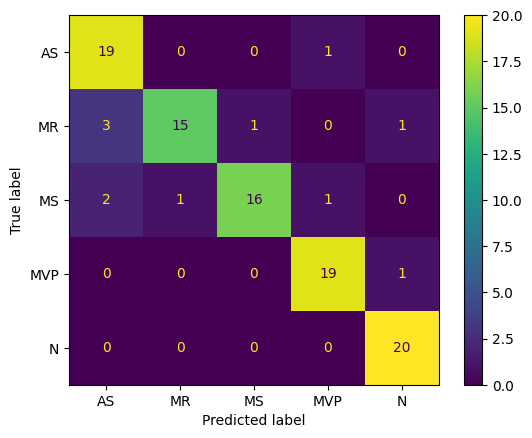

Accuracy : [0.94 0.94 0.95 0.97 0.98] mean:  0.9559999999999998
Precision : [0.79166667 0.9375     0.94117647 0.9047619  0.90909091] mean:  0.896839190221543
Sensitivity : [0.95 0.75 0.8  0.95 1.  ] mean:  0.89
Specificity : [0.9375 0.9875 0.9875 0.975  0.975 ] mean:  0.9724999999999999
f1_score: [0.86363636 0.83333333 0.86486486 0.92682927 0.95238095] mean:  0.8882089565016393



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L6.csv_2.h5
4/4 [==============================] - 0s 5ms/step


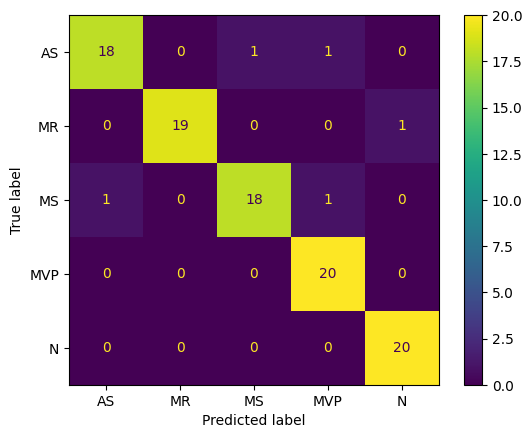

Accuracy : [0.97 0.99 0.97 0.98 0.99] mean:  0.9799999999999999
Precision : [0.94736842 1.         0.94736842 0.90909091 0.95238095] mean:  0.9512417407154249
Sensitivity : [0.9  0.95 0.9  1.   1.  ] mean:  0.95
Specificity : [0.9875 1.     0.9875 0.975  0.9875] mean:  0.9875
f1_score: [0.92307692 0.97435897 0.92307692 0.95238095 0.97560976] mean:  0.9497007057982667



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L7.csv_2.h5
4/4 [==============================] - 0s 5ms/step


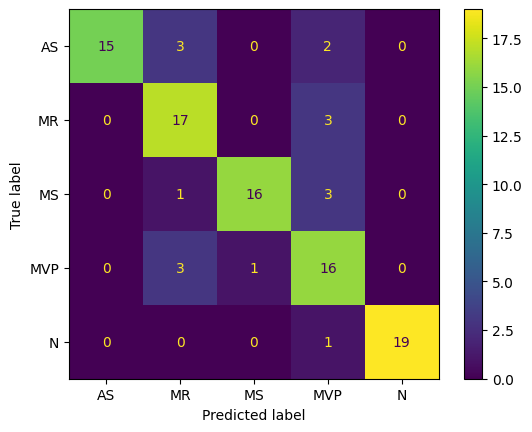

Accuracy : [0.95 0.9  0.95 0.87 0.99] mean:  0.932
Precision : [1.         0.70833333 0.94117647 0.64       1.        ] mean:  0.8579019607843137
Sensitivity : [0.75 0.85 0.8  0.8  0.95] mean:  0.8300000000000001
Specificity : [1.     0.9125 0.9875 0.8875 1.    ] mean:  0.9575000000000001
f1_score: [0.85714286 0.77272727 0.86486486 0.71111111 0.97435897] mean:  0.836041016041016



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L8.csv_5.h5
4/4 [==============================] - 0s 5ms/step


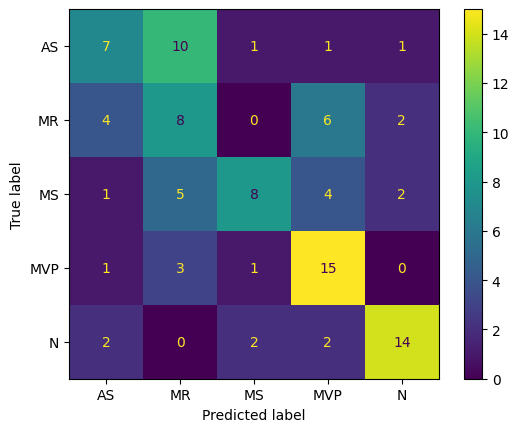

Accuracy : [0.79 0.7  0.84 0.82 0.89] mean:  0.808
Precision : [0.46666667 0.30769231 0.66666667 0.53571429 0.73684211] mean:  0.5427164064006169
Sensitivity : [0.35 0.4  0.4  0.75 0.7 ] mean:  0.5199999999999999
Specificity : [0.9    0.775  0.95   0.8375 0.9375] mean:  0.8800000000000001
f1_score: [0.4        0.34782609 0.5        0.625      0.71794872] mean:  0.518154960981048



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L9.csv_3.h5
4/4 [==============================] - 0s 4ms/step


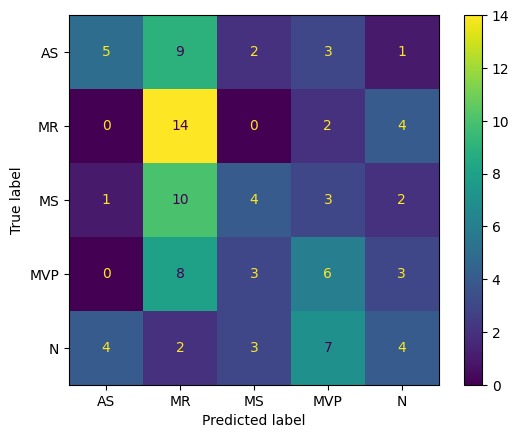

Accuracy : [0.8  0.65 0.76 0.71 0.74] mean:  0.732
Precision : [0.5        0.3255814  0.33333333 0.28571429 0.28571429] mean:  0.3460686600221484
Sensitivity : [0.25 0.7  0.2  0.3  0.2 ] mean:  0.32999999999999996
Specificity : [0.9375 0.6375 0.9    0.8125 0.875 ] mean:  0.8324999999999999
f1_score: [0.33333333 0.44444444 0.25       0.29268293 0.23529412] mean:  0.311150964450821



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb5L10.csv_4.h5
4/4 [==============================] - 0s 5ms/step


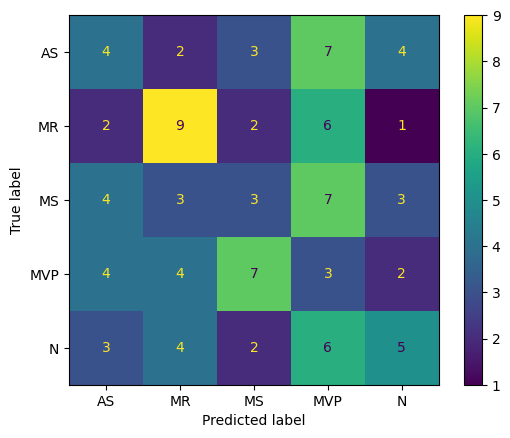

Accuracy : [0.71 0.76 0.69 0.57 0.75] mean:  0.696
Precision : [0.23529412 0.40909091 0.17647059 0.10344828 0.33333333] mean:  0.2515274448337329
Sensitivity : [0.2  0.45 0.15 0.15 0.25] mean:  0.24000000000000005
Specificity : [0.8375 0.8375 0.825  0.675  0.875 ] mean:  0.8099999999999999
f1_score: [0.21621622 0.42857143 0.16216216 0.12244898 0.28571429] mean:  0.24302261445118592



Accuracy All : [0.8400000000000001, 0.9119999999999999, 0.924, 0.968, 0.9559999999999998, 0.9799999999999999, 0.932, 0.808, 0.732, 0.696]
Precision All : [0.5865308107635474, 0.7859264918088448, 0.8168754036528971, 0.9261196469434456, 0.896839190221543, 0.9512417407154249, 0.8579019607843137, 0.5427164064006169, 0.3460686600221484, 0.2515274448337329]
Sensitivity All : [0.6, 0.78, 0.8099999999999999, 0.9199999999999999, 0.89, 0.95, 0.8300000000000001, 0.5199999999999999, 0.32999999999999996, 0.24000000000000005]
Specificity All : [0.9, 0.9450000000000001, 0.9525, 0.9799999999999999, 0.9724999999999999, 0.

In [17]:
testingVHD(a5, 5)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L1.csv_3.h5


4/4 [==============================] - 0s 5ms/step


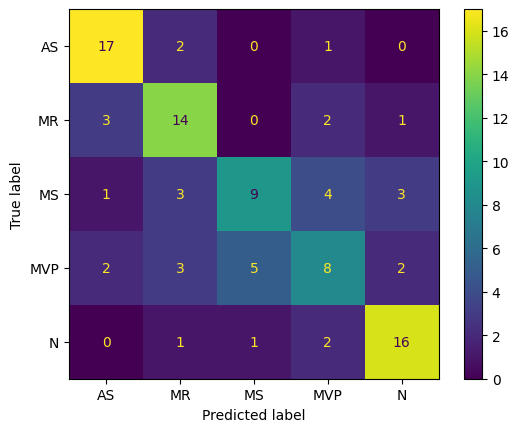

Accuracy : [0.91 0.85 0.83 0.79 0.9 ] mean:  0.8560000000000001
Precision : [0.73913043 0.60869565 0.6        0.47058824 0.72727273] mean:  0.6291374099046733
Sensitivity : [0.85 0.7  0.45 0.4  0.8 ] mean:  0.64
Specificity : [0.925  0.8875 0.925  0.8875 0.925 ] mean:  0.9099999999999999
f1_score: [0.79069767 0.65116279 0.51428571 0.43243243 0.76190476] mean:  0.6300966747478375



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L2.csv_4.h5
4/4 [==============================] - 0s 6ms/step


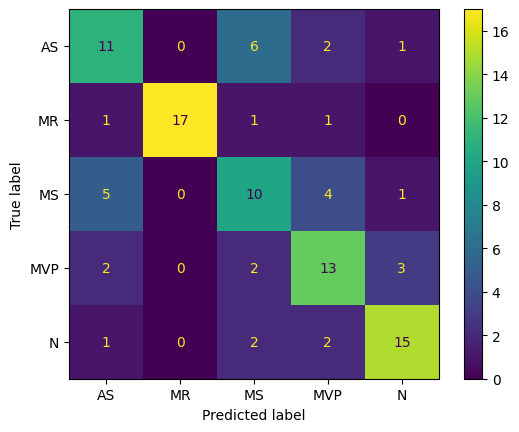

Accuracy : [0.82 0.97 0.79 0.84 0.9 ] mean:  0.8640000000000001
Precision : [0.55       1.         0.47619048 0.59090909 0.75      ] mean:  0.6734199134199134
Sensitivity : [0.55 0.85 0.5  0.65 0.75] mean:  0.6599999999999999
Specificity : [0.8875 1.     0.8625 0.8875 0.9375] mean:  0.915
f1_score: [0.55       0.91891892 0.48780488 0.61904762 0.75      ] mean:  0.6651542832030637



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L3.csv_2.h5
4/4 [==============================] - 0s 4ms/step


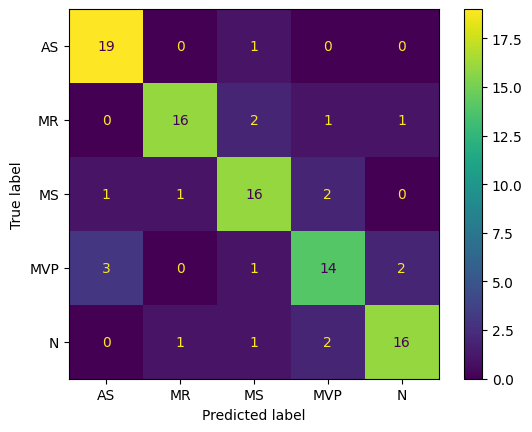

Accuracy : [0.95 0.94 0.91 0.89 0.93] mean:  0.924
Precision : [0.82608696 0.88888889 0.76190476 0.73684211 0.84210526] mean:  0.8111655951472885
Sensitivity : [0.95 0.8  0.8  0.7  0.8 ] mean:  0.8099999999999999
Specificity : [0.95   0.975  0.9375 0.9375 0.9625] mean:  0.9525
f1_score: [0.88372093 0.84210526 0.7804878  0.71794872 0.82051282] mean:  0.8089551073460081



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L4.csv_3.h5
4/4 [==============================] - 0s 5ms/step


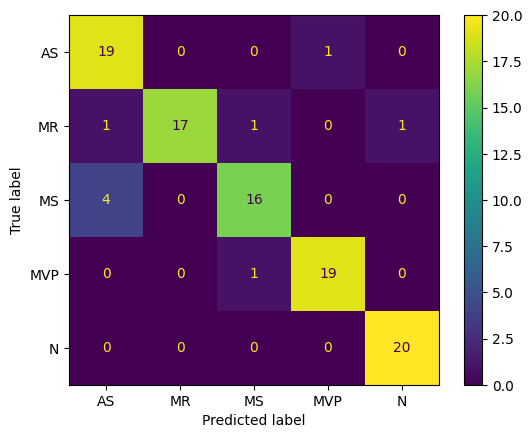

Accuracy : [0.94 0.97 0.94 0.98 0.99] mean:  0.9639999999999999
Precision : [0.79166667 1.         0.88888889 0.95       0.95238095] mean:  0.9165873015873016
Sensitivity : [0.95 0.85 0.8  0.95 1.  ] mean:  0.9099999999999999
Specificity : [0.9375 1.     0.975  0.9875 0.9875] mean:  0.9775
f1_score: [0.86363636 0.91891892 0.84210526 0.95       0.97560976] mean:  0.9100540603621476



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


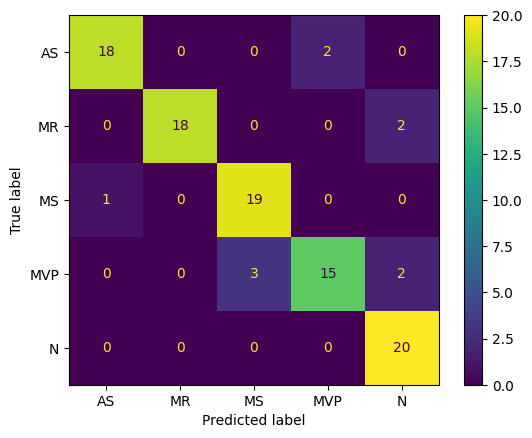

Accuracy : [0.97 0.98 0.96 0.93 0.96] mean:  0.9600000000000002
Precision : [0.94736842 1.         0.86363636 0.88235294 0.83333333] mean:  0.9053382118397598
Sensitivity : [0.9  0.9  0.95 0.75 1.  ] mean:  0.9
Specificity : [0.9875 1.     0.9625 0.975  0.95  ] mean:  0.975
f1_score: [0.92307692 0.94736842 0.9047619  0.81081081 0.90909091] mean:  0.8990217937586358



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


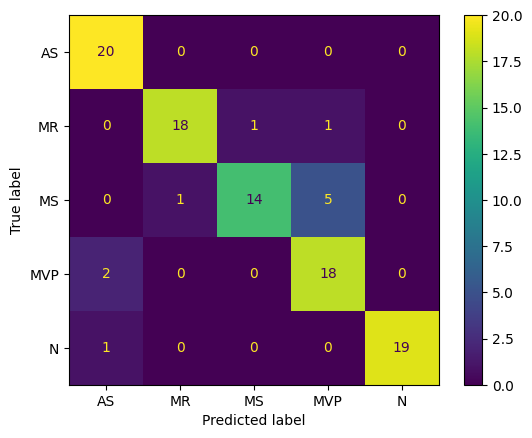

Accuracy : [0.97 0.97 0.93 0.92 0.99] mean:  0.9560000000000001
Precision : [0.86956522 0.94736842 0.93333333 0.75       1.        ] mean:  0.9000533943554538
Sensitivity : [1.   0.9  0.7  0.9  0.95] mean:  0.8899999999999999
Specificity : [0.9625 0.9875 0.9875 0.925  1.    ] mean:  0.9724999999999999
f1_score: [0.93023256 0.92307692 0.8        0.81818182 0.97435897] mean:  0.8891700547514502



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L7.csv_3.h5
4/4 [==============================] - 0s 5ms/step


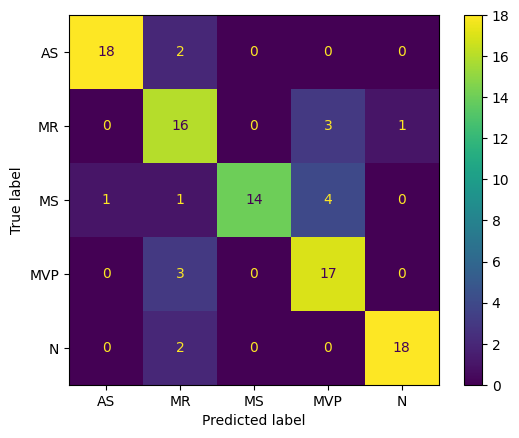

Accuracy : [0.97 0.88 0.94 0.9  0.97] mean:  0.932
Precision : [0.94736842 0.66666667 1.         0.70833333 0.94736842] mean:  0.8539473684210526
Sensitivity : [0.9  0.8  0.7  0.85 0.9 ] mean:  0.8300000000000001
Specificity : [0.9875 0.9    1.     0.9125 0.9875] mean:  0.9575000000000001
f1_score: [0.92307692 0.72727273 0.82352941 0.77272727 0.92307692] mean:  0.8339366515837104



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L8.csv_4.h5
4/4 [==============================] - 0s 5ms/step


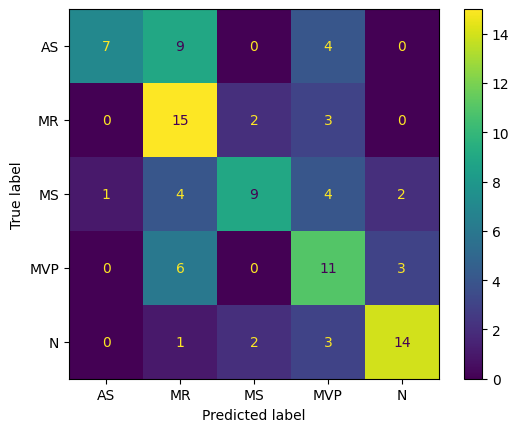

Accuracy : [0.86 0.75 0.85 0.77 0.89] mean:  0.8240000000000001
Precision : [0.875      0.42857143 0.69230769 0.44       0.73684211] mean:  0.6345442452284558
Sensitivity : [0.35 0.75 0.45 0.55 0.7 ] mean:  0.5599999999999999
Specificity : [0.9875 0.75   0.95   0.825  0.9375] mean:  0.89
f1_score: [0.5        0.54545455 0.54545455 0.48888889 0.71794872] mean:  0.5595493395493396



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L9.csv_3.h5
4/4 [==============================] - 0s 4ms/step


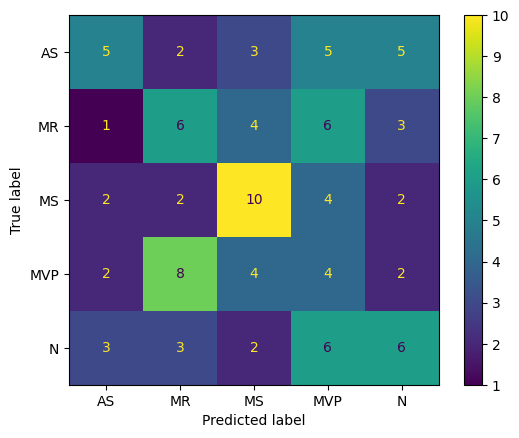

Accuracy : [0.77 0.71 0.77 0.63 0.74] mean:  0.724
Precision : [0.38461538 0.28571429 0.43478261 0.16       0.33333333] mean:  0.31968912247173115
Sensitivity : [0.25 0.3  0.5  0.2  0.3 ] mean:  0.31
Specificity : [0.9    0.8125 0.8375 0.7375 0.85  ] mean:  0.8274999999999999
f1_score: [0.3030303  0.29268293 0.46511628 0.17777778 0.31578947] mean:  0.3108793520782654



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb6L10.csv_3.h5
4/4 [==============================] - 0s 5ms/step


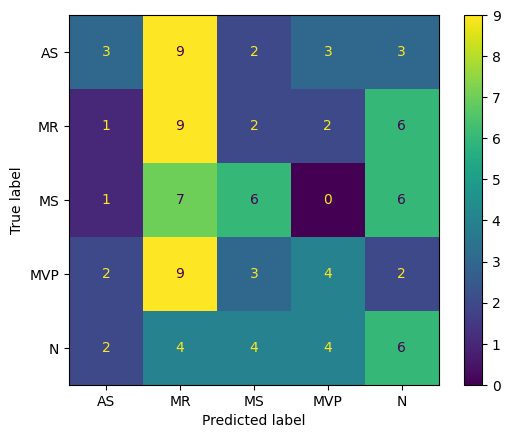

Accuracy : [0.77 0.6  0.75 0.75 0.69] mean:  0.712
Precision : [0.33333333 0.23684211 0.35294118 0.30769231 0.26086957] mean:  0.2983356975953557
Sensitivity : [0.15 0.45 0.3  0.2  0.3 ] mean:  0.27999999999999997
Specificity : [0.925  0.6375 0.8625 0.8875 0.7875] mean:  0.82
f1_score: [0.20689655 0.31034483 0.32432432 0.24242424 0.27906977] mean:  0.27261194270015443



Accuracy All : [0.8560000000000001, 0.8640000000000001, 0.924, 0.9639999999999999, 0.9600000000000002, 0.9560000000000001, 0.932, 0.8240000000000001, 0.724, 0.712]
Precision All : [0.6291374099046733, 0.6734199134199134, 0.8111655951472885, 0.9165873015873016, 0.9053382118397598, 0.9000533943554538, 0.8539473684210526, 0.6345442452284558, 0.31968912247173115, 0.2983356975953557]
Sensitivity All : [0.64, 0.6599999999999999, 0.8099999999999999, 0.9099999999999999, 0.9, 0.8899999999999999, 0.8300000000000001, 0.5599999999999999, 0.31, 0.27999999999999997]
Specificity All : [0.9099999999999999, 0.915, 0.9525, 0.9775, 0.975

In [18]:
testingVHD(a6, 6)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L1.csv_5.h5


4/4 [==============================] - 0s 5ms/step


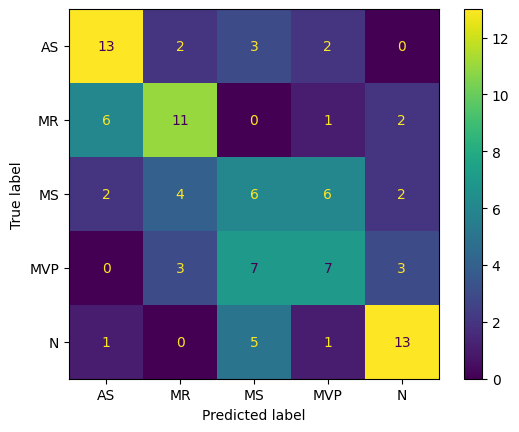

Accuracy : [0.84 0.82 0.71 0.77 0.86] mean:  0.8
Precision : [0.59090909 0.55       0.28571429 0.41176471 0.65      ] mean:  0.4976776165011459
Sensitivity : [0.65 0.55 0.3  0.35 0.65] mean:  0.5
Specificity : [0.8875 0.8875 0.8125 0.875  0.9125] mean:  0.875
f1_score: [0.61904762 0.55       0.29268293 0.37837838 0.65      ] mean:  0.4980217848510532



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L2.csv_3.h5
4/4 [==============================] - 0s 4ms/step


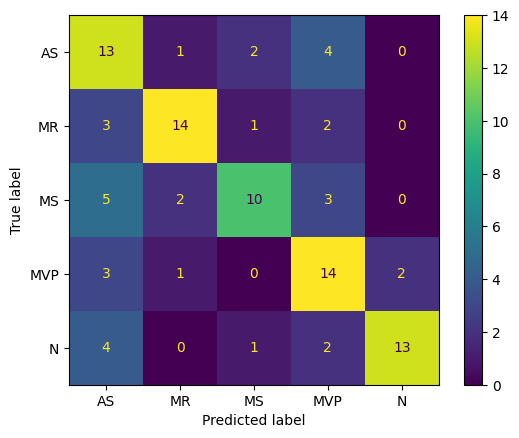

Accuracy : [0.78 0.9  0.86 0.83 0.91] mean:  0.8560000000000001
Precision : [0.46428571 0.77777778 0.71428571 0.56       0.86666667] mean:  0.6766031746031747
Sensitivity : [0.65 0.7  0.5  0.7  0.65] mean:  0.6399999999999999
Specificity : [0.8125 0.95   0.95   0.8625 0.975 ] mean:  0.9099999999999999
f1_score: [0.54166667 0.73684211 0.58823529 0.62222222 0.74285714] mean:  0.6463646862253674



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L3.csv_3.h5
4/4 [==============================] - 0s 5ms/step


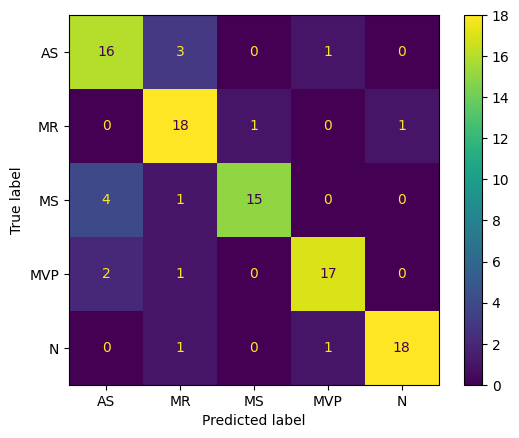

Accuracy : [0.9  0.92 0.94 0.95 0.97] mean:  0.9359999999999999
Precision : [0.72727273 0.75       0.9375     0.89473684 0.94736842] mean:  0.8513755980861244
Sensitivity : [0.8  0.9  0.75 0.85 0.9 ] mean:  0.8400000000000001
Specificity : [0.925  0.925  0.9875 0.975  0.9875] mean:  0.9600000000000002
f1_score: [0.76190476 0.81818182 0.83333333 0.87179487 0.92307692] mean:  0.8416583416583417



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L4.csv_3.h5
4/4 [==============================] - 0s 5ms/step


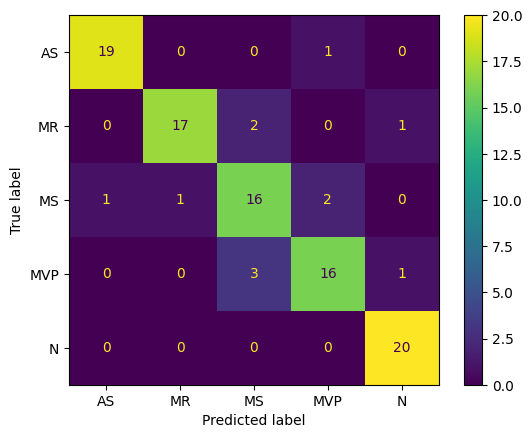

Accuracy : [0.98 0.96 0.91 0.93 0.98] mean:  0.952
Precision : [0.95       0.94444444 0.76190476 0.84210526 0.90909091] mean:  0.8815090757196019
Sensitivity : [0.95 0.85 0.8  0.8  1.  ] mean:  0.8799999999999999
Specificity : [0.9875 0.9875 0.9375 0.9625 0.975 ] mean:  0.97
f1_score: [0.95       0.89473684 0.7804878  0.82051282 0.95238095] mean:  0.879623683975417



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L5.csv_2.h5
4/4 [==============================] - 0s 4ms/step


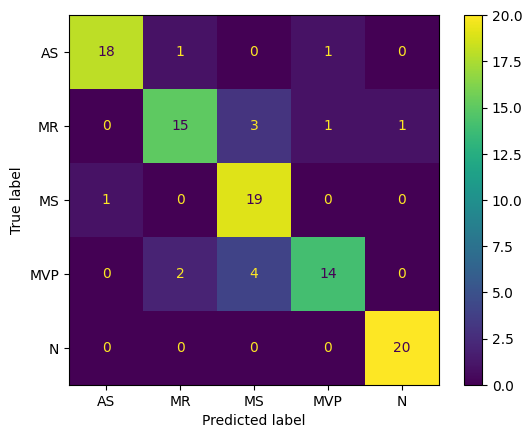

Accuracy : [0.97 0.92 0.92 0.92 0.99] mean:  0.944
Precision : [0.94736842 0.83333333 0.73076923 0.875      0.95238095] mean:  0.8677703875072297
Sensitivity : [0.9  0.75 0.95 0.7  1.  ] mean:  0.86
Specificity : [0.9875 0.9625 0.9125 0.975  0.9875] mean:  0.9650000000000001
f1_score: [0.92307692 0.78947368 0.82608696 0.77777778 0.97560976] mean:  0.8584050195369055



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L6.csv_4.h5
4/4 [==============================] - 0s 5ms/step


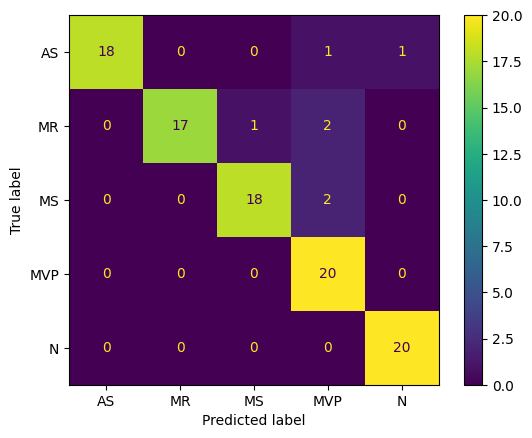

Accuracy : [0.98 0.97 0.97 0.95 0.99] mean:  0.9720000000000001
Precision : [1.         1.         0.94736842 0.8        0.95238095] mean:  0.9399498746867169
Sensitivity : [0.9  0.85 0.9  1.   1.  ] mean:  0.93
Specificity : [1.     1.     0.9875 0.9375 0.9875] mean:  0.9824999999999999
f1_score: [0.94736842 0.91891892 0.92307692 0.88888889 0.97560976] mean:  0.9307725816069847



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L7.csv_5.h5
4/4 [==============================] - 0s 5ms/step


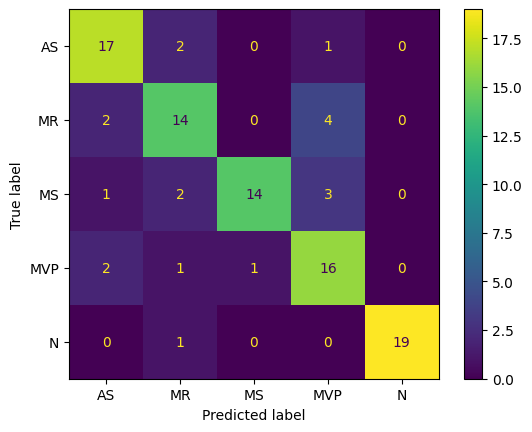

Accuracy : [0.92 0.88 0.93 0.88 0.99] mean:  0.9199999999999999
Precision : [0.77272727 0.7        0.93333333 0.66666667 1.        ] mean:  0.8145454545454545
Sensitivity : [0.85 0.7  0.7  0.8  0.95] mean:  0.8
Specificity : [0.9375 0.925  0.9875 0.9    1.    ] mean:  0.95
f1_score: [0.80952381 0.7        0.8        0.72727273 0.97435897] mean:  0.8022311022311021



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L8.csv_5.h5
4/4 [==============================] - 0s 5ms/step


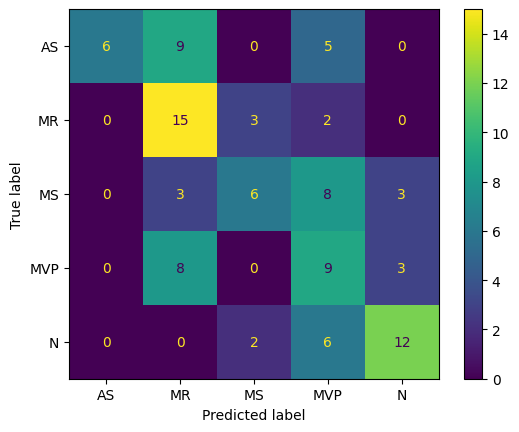

Accuracy : [0.86 0.75 0.81 0.68 0.86] mean:  0.792
Precision : [1.         0.42857143 0.54545455 0.3        0.66666667] mean:  0.5881385281385281
Sensitivity : [0.3  0.75 0.3  0.45 0.6 ] mean:  0.48
Specificity : [1.     0.75   0.9375 0.7375 0.925 ] mean:  0.8699999999999999
f1_score: [0.46153846 0.54545455 0.38709677 0.36       0.63157895] mean:  0.47713374571099526



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L9.csv_3.h5
4/4 [==============================] - 0s 4ms/step


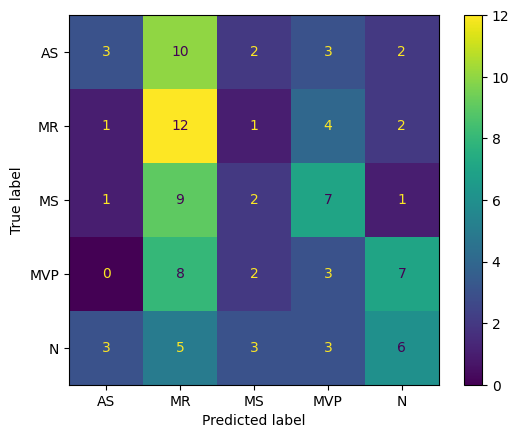

Accuracy : [0.78 0.6  0.74 0.66 0.74] mean:  0.7040000000000001
Precision : [0.375      0.27272727 0.2        0.15       0.33333333] mean:  0.26621212121212123
Sensitivity : [0.15 0.6  0.1  0.15 0.3 ] mean:  0.26
Specificity : [0.9375 0.6    0.9    0.7875 0.85  ] mean:  0.8150000000000001
f1_score: [0.21428571 0.375      0.13333333 0.15       0.31578947] mean:  0.2376817042606516



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb7L10.csv_1.h5
4/4 [==============================] - 0s 5ms/step


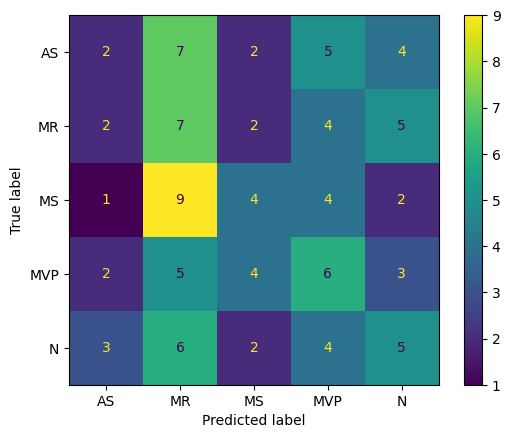

Accuracy : [0.74 0.6  0.74 0.69 0.71] mean:  0.696
Precision : [0.2        0.20588235 0.28571429 0.26086957 0.26315789] mean:  0.2431248197219391
Sensitivity : [0.1  0.35 0.2  0.3  0.25] mean:  0.24
Specificity : [0.9    0.6625 0.875  0.7875 0.825 ] mean:  0.8099999999999999
f1_score: [0.13333333 0.25925926 0.23529412 0.27906977 0.25641026] mean:  0.23267334681835367



Accuracy All : [0.8, 0.8560000000000001, 0.9359999999999999, 0.952, 0.944, 0.9720000000000001, 0.9199999999999999, 0.792, 0.7040000000000001, 0.696]
Precision All : [0.4976776165011459, 0.6766031746031747, 0.8513755980861244, 0.8815090757196019, 0.8677703875072297, 0.9399498746867169, 0.8145454545454545, 0.5881385281385281, 0.26621212121212123, 0.2431248197219391]
Sensitivity All : [0.5, 0.6399999999999999, 0.8400000000000001, 0.8799999999999999, 0.86, 0.93, 0.8, 0.48, 0.26, 0.24]
Specificity All : [0.875, 0.9099999999999999, 0.9600000000000002, 0.97, 0.9650000000000001, 0.9824999999999999, 0.95, 0.8699999999999999, 0.8

In [19]:
testingVHD(a7, 7)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L1.csv_3.h5


4/4 [==============================] - 0s 5ms/step


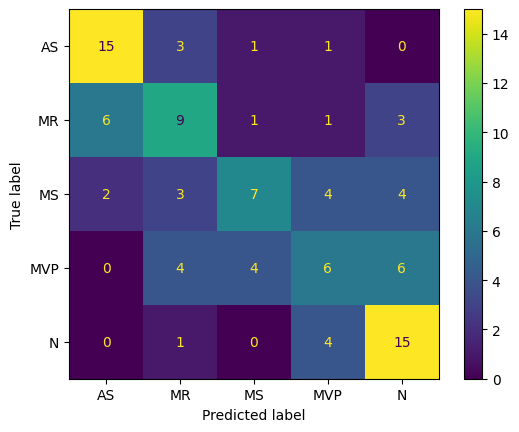

Accuracy : [0.87 0.78 0.81 0.76 0.82] mean:  0.808
Precision : [0.65217391 0.45       0.53846154 0.375      0.53571429] mean:  0.5102699474438604
Sensitivity : [0.75 0.45 0.35 0.3  0.75] mean:  0.5199999999999999
Specificity : [0.9    0.8625 0.925  0.875  0.8375] mean:  0.8800000000000001
f1_score: [0.69767442 0.45       0.42424242 0.33333333 0.625     ] mean:  0.5060500352360818



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L2.csv_5.h5
4/4 [==============================] - 0s 5ms/step


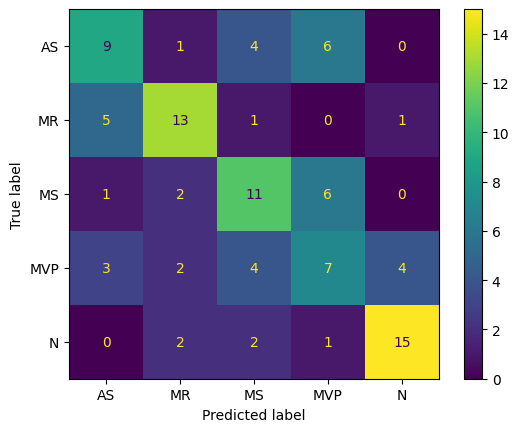

Accuracy : [0.8  0.86 0.8  0.74 0.9 ] mean:  0.8200000000000001
Precision : [0.5  0.65 0.5  0.35 0.75] mean:  0.55
Sensitivity : [0.45 0.65 0.55 0.35 0.75] mean:  0.55
Specificity : [0.8875 0.9125 0.8625 0.8375 0.9375] mean:  0.8875
f1_score: [0.47368421 0.65       0.52380952 0.35       0.75      ] mean:  0.5494987468671679



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L3.csv_2.h5
4/4 [==============================] - 0s 5ms/step


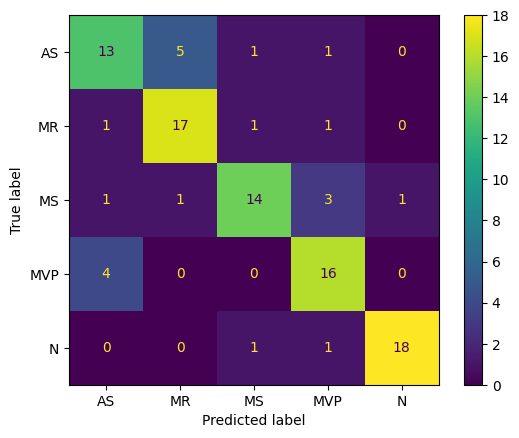

Accuracy : [0.87 0.91 0.91 0.9  0.97] mean:  0.9119999999999999
Precision : [0.68421053 0.73913043 0.82352941 0.72727273 0.94736842] mean:  0.7843023042376926
Sensitivity : [0.65 0.85 0.7  0.8  0.9 ] mean:  0.78
Specificity : [0.925  0.925  0.9625 0.925  0.9875] mean:  0.945
f1_score: [0.66666667 0.79069767 0.75675676 0.76190476 0.92307692] mean:  0.7798205565647425



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L4.csv_5.h5
4/4 [==============================] - 0s 4ms/step


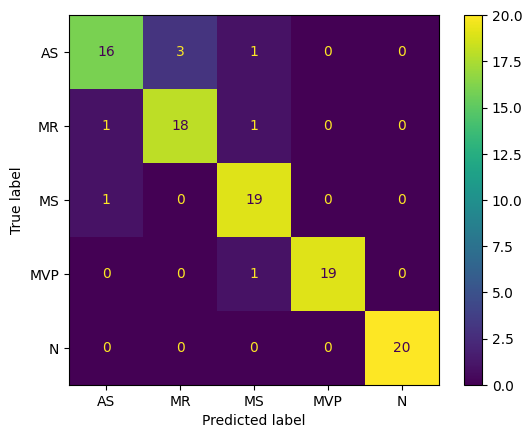

Accuracy : [0.94 0.95 0.96 0.99 1.  ] mean:  0.968
Precision : [0.88888889 0.85714286 0.86363636 1.         1.        ] mean:  0.921933621933622
Sensitivity : [0.8  0.9  0.95 0.95 1.  ] mean:  0.9200000000000002
Specificity : [0.975  0.9625 0.9625 1.     1.    ] mean:  0.9800000000000001
f1_score: [0.84210526 0.87804878 0.9047619  0.97435897 1.        ] mean:  0.9198549845533158



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


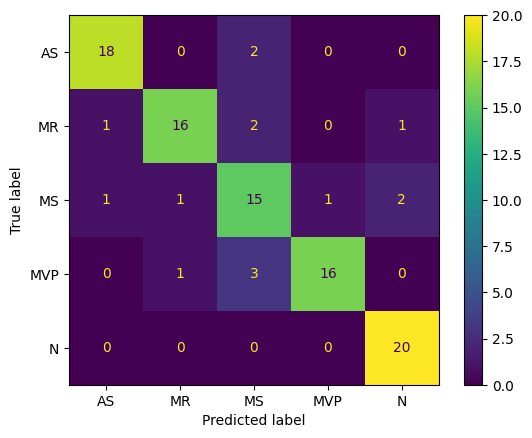

Accuracy : [0.96 0.94 0.88 0.95 0.97] mean:  0.9399999999999998
Precision : [0.9        0.88888889 0.68181818 0.94117647 0.86956522] mean:  0.8562897517373221
Sensitivity : [0.9  0.8  0.75 0.8  1.  ] mean:  0.85
Specificity : [0.975  0.975  0.9125 0.9875 0.9625] mean:  0.9625
f1_score: [0.9        0.84210526 0.71428571 0.86486486 0.93023256] mean:  0.8502976800896018



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L6.csv_4.h5
4/4 [==============================] - 0s 4ms/step


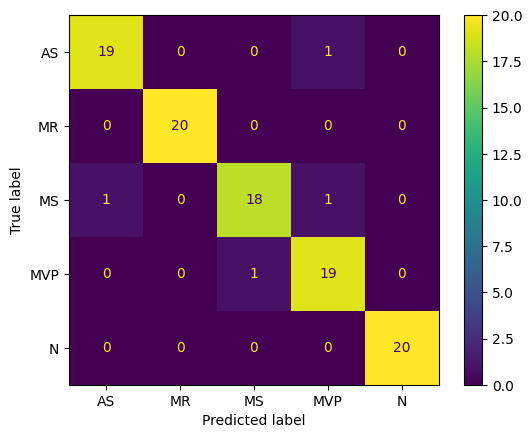

Accuracy : [0.98 1.   0.97 0.97 1.  ] mean:  0.984
Precision : [0.95       1.         0.94736842 0.9047619  1.        ] mean:  0.9604260651629073
Sensitivity : [0.95 1.   0.9  0.95 1.  ] mean:  0.96
Specificity : [0.9875 1.     0.9875 0.975  1.    ] mean:  0.99
f1_score: [0.95       1.         0.92307692 0.92682927 1.        ] mean:  0.9599812382739212



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L7.csv_5.h5
4/4 [==============================] - 0s 4ms/step


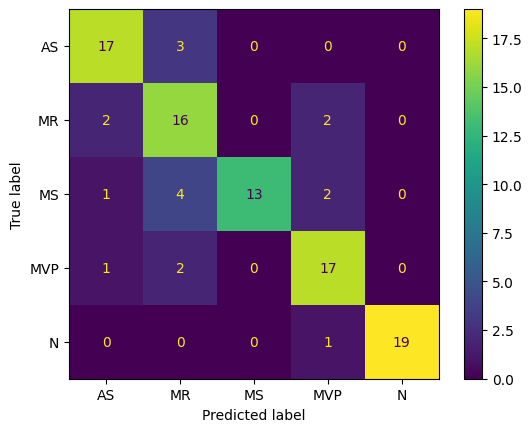

Accuracy : [0.93 0.87 0.93 0.92 0.99] mean:  0.9279999999999999
Precision : [0.80952381 0.64       1.         0.77272727 1.        ] mean:  0.8444502164502165
Sensitivity : [0.85 0.8  0.65 0.85 0.95] mean:  0.82
Specificity : [0.95   0.8875 1.     0.9375 1.    ] mean:  0.9550000000000001
f1_score: [0.82926829 0.71111111 0.78787879 0.80952381 0.97435897] mean:  0.822428195111122



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L8.csv_5.h5
4/4 [==============================] - 0s 5ms/step


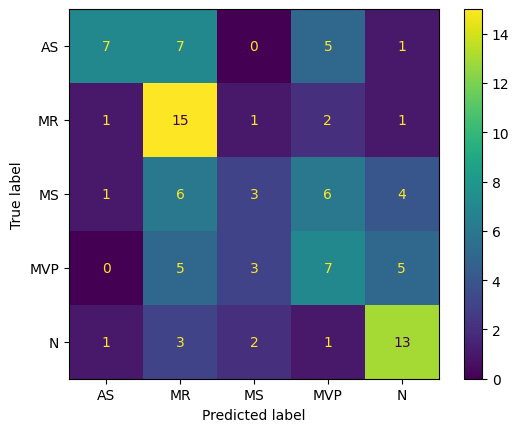

Accuracy : [0.84 0.74 0.77 0.73 0.82] mean:  0.78
Precision : [0.7        0.41666667 0.33333333 0.33333333 0.54166667] mean:  0.46499999999999997
Sensitivity : [0.35 0.75 0.15 0.35 0.65] mean:  0.45
Specificity : [0.9625 0.7375 0.925  0.825  0.8625] mean:  0.8625
f1_score: [0.46666667 0.53571429 0.20689655 0.34146341 0.59090909] mean:  0.42833000192966547



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L9.csv_5.h5
4/4 [==============================] - 0s 4ms/step


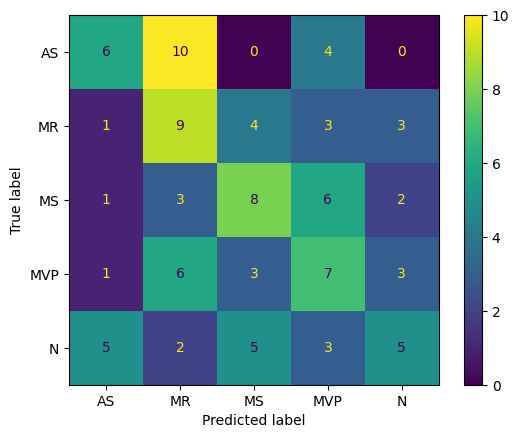

Accuracy : [0.78 0.68 0.76 0.71 0.77] mean:  0.74
Precision : [0.42857143 0.3        0.4        0.30434783 0.38461538] mean:  0.3635069278547539
Sensitivity : [0.3  0.45 0.4  0.35 0.25] mean:  0.35
Specificity : [0.9    0.7375 0.85   0.8    0.9   ] mean:  0.8375000000000001
f1_score: [0.35294118 0.36       0.4        0.3255814  0.3030303 ] mean:  0.34831057496994566



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb8L10.csv_3.h5
4/4 [==============================] - 0s 5ms/step


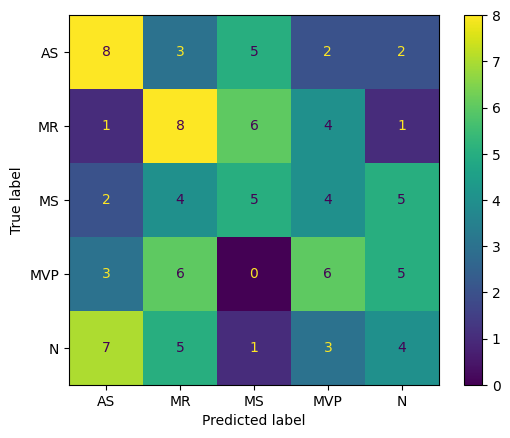

Accuracy : [0.75 0.7  0.73 0.73 0.71] mean:  0.724
Precision : [0.38095238 0.30769231 0.29411765 0.31578947 0.23529412] mean:  0.30676918540695636
Sensitivity : [0.4  0.4  0.25 0.3  0.2 ] mean:  0.31
Specificity : [0.8375 0.775  0.85   0.8375 0.8375] mean:  0.8275
f1_score: [0.3902439  0.34782609 0.27027027 0.30769231 0.21621622] mean:  0.30644975671486807



Accuracy All : [0.808, 0.8200000000000001, 0.9119999999999999, 0.968, 0.9399999999999998, 0.984, 0.9279999999999999, 0.78, 0.74, 0.724]
Precision All : [0.5102699474438604, 0.55, 0.7843023042376926, 0.921933621933622, 0.8562897517373221, 0.9604260651629073, 0.8444502164502165, 0.46499999999999997, 0.3635069278547539, 0.30676918540695636]
Sensitivity All : [0.5199999999999999, 0.55, 0.78, 0.9200000000000002, 0.85, 0.96, 0.82, 0.45, 0.35, 0.31]
Specificity All : [0.8800000000000001, 0.8875, 0.945, 0.9800000000000001, 0.9625, 0.99, 0.9550000000000001, 0.8625, 0.8375000000000001, 0.8275]
f1_score All : [0.5060500352360818, 0.549498746

In [20]:
testingVHD(a8, 8)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L1.csv_5.h5


4/4 [==============================] - 0s 5ms/step


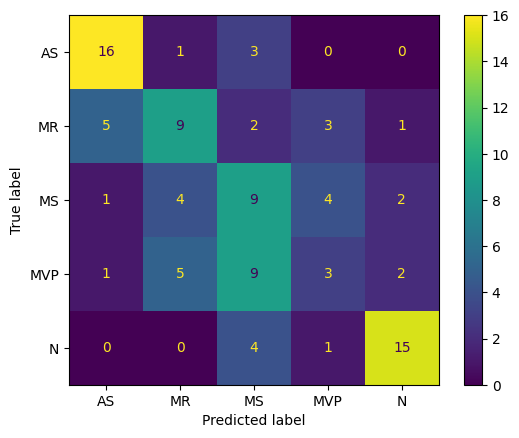

Accuracy : [0.89 0.79 0.71 0.75 0.9 ] mean:  0.808
Precision : [0.69565217 0.47368421 0.33333333 0.27272727 0.75      ] mean:  0.505079398099993
Sensitivity : [0.8  0.45 0.45 0.15 0.75] mean:  0.5199999999999999
Specificity : [0.9125 0.875  0.775  0.9    0.9375] mean:  0.8800000000000001
f1_score: [0.74418605 0.46153846 0.38297872 0.19354839 0.75      ] mean:  0.5064503237102238



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L2.csv_4.h5
4/4 [==============================] - 0s 5ms/step


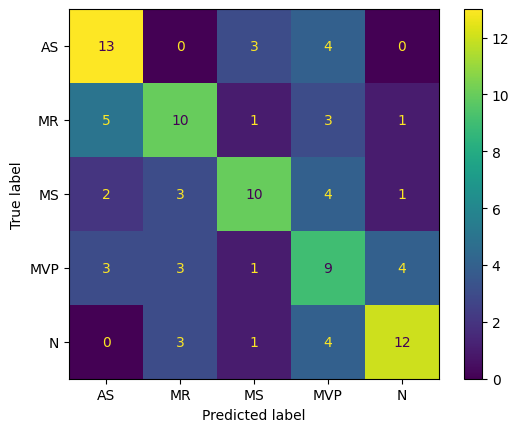

Accuracy : [0.83 0.81 0.84 0.74 0.86] mean:  0.8160000000000001
Precision : [0.56521739 0.52631579 0.625      0.375      0.66666667] mean:  0.5516399694889397
Sensitivity : [0.65 0.5  0.5  0.45 0.6 ] mean:  0.54
Specificity : [0.875  0.8875 0.925  0.8125 0.925 ] mean:  0.885
f1_score: [0.60465116 0.51282051 0.55555556 0.40909091 0.63157895] mean:  0.5427394175252193



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L3.csv_2.h5
4/4 [==============================] - 0s 5ms/step


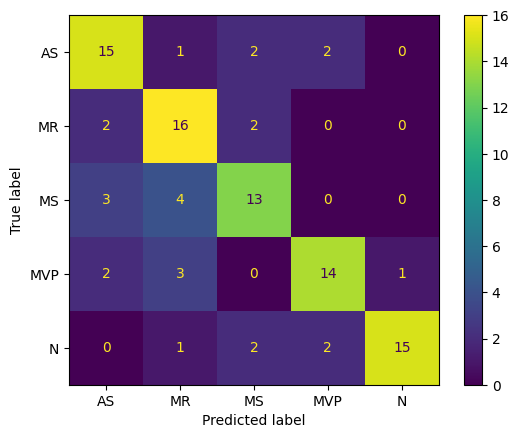

Accuracy : [0.88 0.87 0.87 0.9  0.94] mean:  0.892
Precision : [0.68181818 0.64       0.68421053 0.77777778 0.9375    ] mean:  0.7442612971823498
Sensitivity : [0.75 0.8  0.65 0.7  0.75] mean:  0.7300000000000001
Specificity : [0.9125 0.8875 0.925  0.95   0.9875] mean:  0.9324999999999999
f1_score: [0.71428571 0.71111111 0.66666667 0.73684211 0.83333333] mean:  0.7324477861319967



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L4.csv_2.h5
4/4 [==============================] - 0s 5ms/step


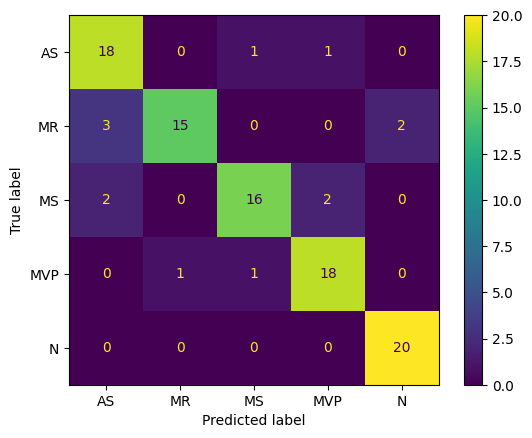

Accuracy : [0.93 0.94 0.94 0.95 0.98] mean:  0.9480000000000001
Precision : [0.7826087  0.9375     0.88888889 0.85714286 0.90909091] mean:  0.8750462701549658
Sensitivity : [0.9  0.75 0.8  0.9  1.  ] mean:  0.8699999999999999
Specificity : [0.9375 0.9875 0.975  0.9625 0.975 ] mean:  0.9674999999999999
f1_score: [0.8372093  0.83333333 0.84210526 0.87804878 0.95238095] mean:  0.8686155263371134



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L5.csv_5.h5
4/4 [==============================] - 0s 5ms/step


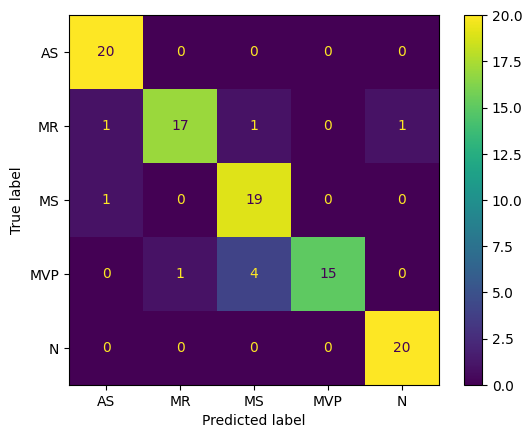

Accuracy : [0.98 0.96 0.94 0.95 0.99] mean:  0.9640000000000001
Precision : [0.90909091 0.94444444 0.79166667 1.         0.95238095] mean:  0.9195165945165945
Sensitivity : [1.   0.85 0.95 0.75 1.  ] mean:  0.9099999999999999
Specificity : [0.975  0.9875 0.9375 1.     0.9875] mean:  0.9775
f1_score: [0.95238095 0.89473684 0.86363636 0.85714286 0.97560976] mean:  0.9087013542725995



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L6.csv_2.h5
4/4 [==============================] - 0s 4ms/step


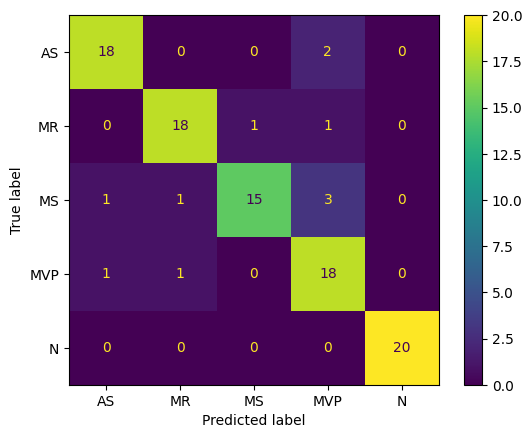

Accuracy : [0.96 0.96 0.94 0.92 1.  ] mean:  0.9559999999999998
Precision : [0.9    0.9    0.9375 0.75   1.    ] mean:  0.8975
Sensitivity : [0.9  0.9  0.75 0.9  1.  ] mean:  0.8899999999999999
Specificity : [0.975  0.975  0.9875 0.925  1.    ] mean:  0.9724999999999999
f1_score: [0.9        0.9        0.83333333 0.81818182 1.        ] mean:  0.8903030303030303



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L7.csv_2.h5
4/4 [==============================] - 0s 5ms/step


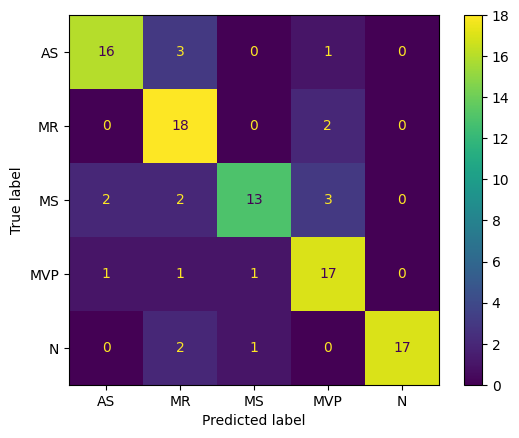

Accuracy : [0.93 0.9  0.91 0.91 0.97] mean:  0.924
Precision : [0.84210526 0.69230769 0.86666667 0.73913043 1.        ] mean:  0.8280420113829724
Sensitivity : [0.8  0.9  0.65 0.85 0.85] mean:  0.8099999999999999
Specificity : [0.9625 0.9    0.975  0.925  1.    ] mean:  0.9525
f1_score: [0.82051282 0.7826087  0.74285714 0.79069767 0.91891892] mean:  0.8111190504719321



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L8.csv_2.h5
4/4 [==============================] - 0s 5ms/step


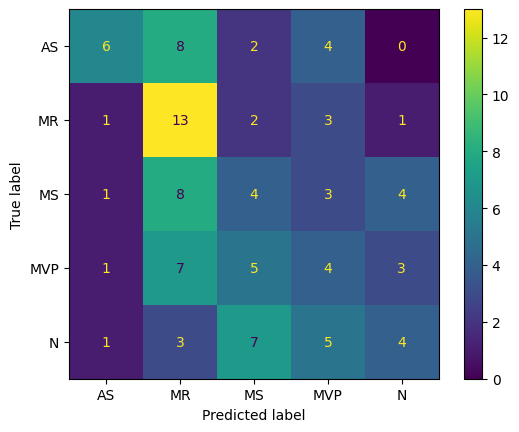

Accuracy : [0.82 0.67 0.68 0.69 0.76] mean:  0.724
Precision : [0.6        0.33333333 0.2        0.21052632 0.33333333] mean:  0.33543859649122804
Sensitivity : [0.3  0.65 0.2  0.2  0.2 ] mean:  0.30999999999999994
Specificity : [0.95   0.675  0.8    0.8125 0.9   ] mean:  0.8275
f1_score: [0.4        0.44067797 0.2        0.20512821 0.25      ] mean:  0.29916123424598



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L9.csv_2.h5
4/4 [==============================] - 0s 5ms/step


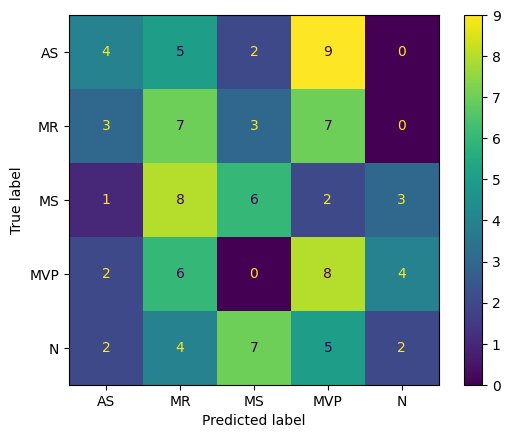

Accuracy : [0.76 0.64 0.74 0.65 0.75] mean:  0.708
Precision : [0.33333333 0.23333333 0.33333333 0.25806452 0.22222222] mean:  0.27605734767025086
Sensitivity : [0.2  0.35 0.3  0.4  0.1 ] mean:  0.27
Specificity : [0.9    0.7125 0.85   0.7125 0.9125] mean:  0.8174999999999999
f1_score: [0.25       0.28       0.31578947 0.31372549 0.13793103] mean:  0.2594891996726095



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb9L10.csv_1.h5
4/4 [==============================] - 0s 5ms/step


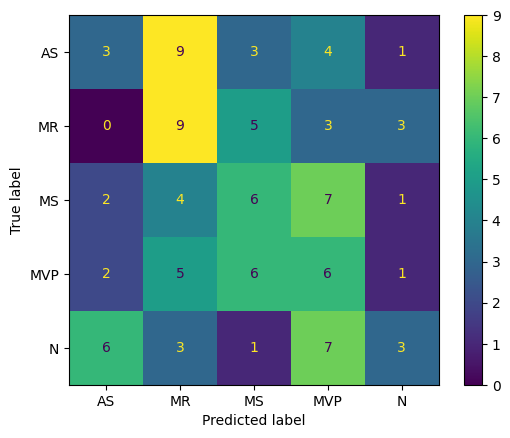

Accuracy : [0.73 0.68 0.71 0.65 0.77] mean:  0.708
Precision : [0.23076923 0.3        0.28571429 0.22222222 0.33333333] mean:  0.27440781440781437
Sensitivity : [0.15 0.45 0.3  0.3  0.15] mean:  0.26999999999999996
Specificity : [0.875  0.7375 0.8125 0.7375 0.925 ] mean:  0.8174999999999999
f1_score: [0.18181818 0.36       0.29268293 0.25531915 0.20689655] mean:  0.2593433618615516



Accuracy All : [0.808, 0.8160000000000001, 0.892, 0.9480000000000001, 0.9640000000000001, 0.9559999999999998, 0.924, 0.724, 0.708, 0.708]
Precision All : [0.505079398099993, 0.5516399694889397, 0.7442612971823498, 0.8750462701549658, 0.9195165945165945, 0.8975, 0.8280420113829724, 0.33543859649122804, 0.27605734767025086, 0.27440781440781437]
Sensitivity All : [0.5199999999999999, 0.54, 0.7300000000000001, 0.8699999999999999, 0.9099999999999999, 0.8899999999999999, 0.8099999999999999, 0.30999999999999994, 0.27, 0.26999999999999996]
Specificity All : [0.8800000000000001, 0.885, 0.9324999999999999, 0.967499

In [21]:
testingVHD(a9, 9)

Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L1.csv_3.h5


4/4 [==============================] - 0s 5ms/step


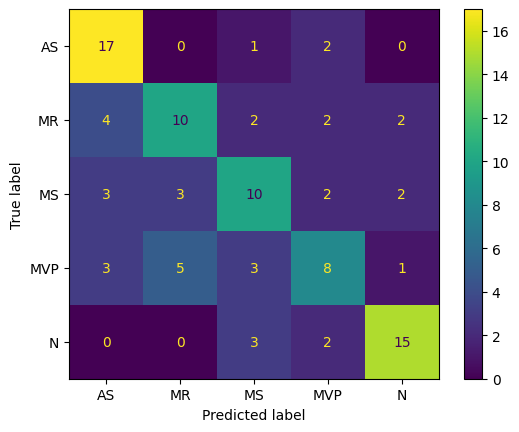

Accuracy : [0.87 0.82 0.81 0.8  0.9 ] mean:  0.8400000000000001
Precision : [0.62962963 0.55555556 0.52631579 0.5        0.75      ] mean:  0.5923001949317739
Sensitivity : [0.85 0.5  0.5  0.4  0.75] mean:  0.6
Specificity : [0.875  0.9    0.8875 0.9    0.9375] mean:  0.9
f1_score: [0.72340426 0.52631579 0.51282051 0.44444444 0.75      ] mean:  0.5913970004115582



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L2.csv_5.h5
4/4 [==============================] - 0s 4ms/step


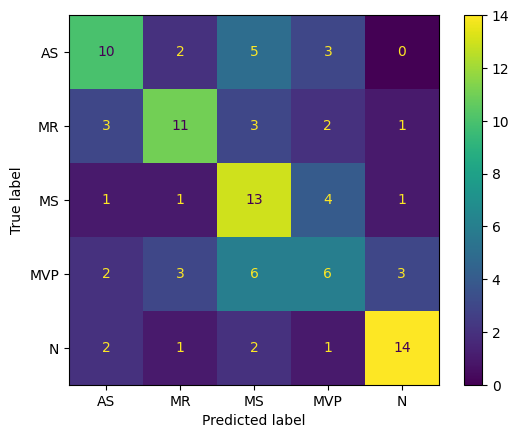

Accuracy : [0.82 0.84 0.77 0.76 0.89] mean:  0.8159999999999998
Precision : [0.55555556 0.61111111 0.44827586 0.375      0.73684211] mean:  0.545356926799758
Sensitivity : [0.5  0.55 0.65 0.3  0.7 ] mean:  0.54
Specificity : [0.9    0.9125 0.8    0.875  0.9375] mean:  0.885
f1_score: [0.52631579 0.57894737 0.53061224 0.33333333 0.71794872] mean:  0.5374314908149495



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L3.csv_3.h5
4/4 [==============================] - 0s 4ms/step


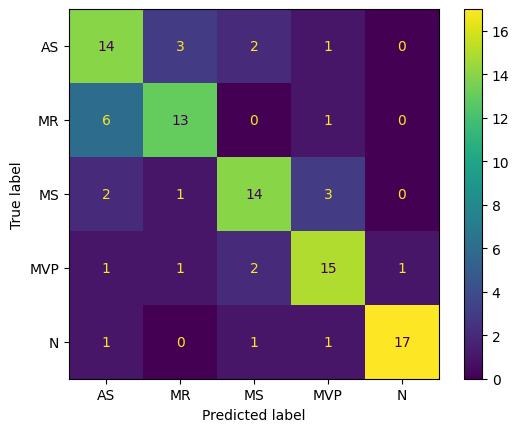

Accuracy : [0.84 0.88 0.89 0.89 0.96] mean:  0.892
Precision : [0.58333333 0.72222222 0.73684211 0.71428571 0.94444444] mean:  0.7402255639097743
Sensitivity : [0.7  0.65 0.7  0.75 0.85] mean:  0.73
Specificity : [0.875  0.9375 0.9375 0.925  0.9875] mean:  0.9324999999999999
f1_score: [0.63636364 0.68421053 0.71794872 0.73170732 0.89473684] mean:  0.7329934079613156



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L4.csv_5.h5
4/4 [==============================] - 0s 5ms/step


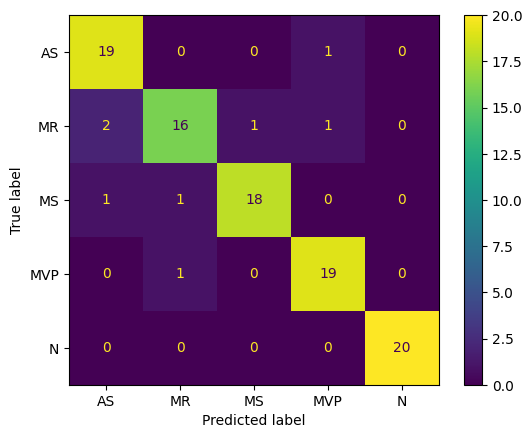

Accuracy : [0.96 0.94 0.97 0.97 1.  ] mean:  0.968
Precision : [0.86363636 0.88888889 0.94736842 0.9047619  1.        ] mean:  0.9209311156679577
Sensitivity : [0.95 0.8  0.9  0.95 1.  ] mean:  0.9199999999999999
Specificity : [0.9625 0.975  0.9875 0.975  1.    ] mean:  0.9800000000000001
f1_score: [0.9047619  0.84210526 0.92307692 0.92682927 1.        ] mean:  0.9193546718578812



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L5.csv_3.h5
4/4 [==============================] - 0s 4ms/step


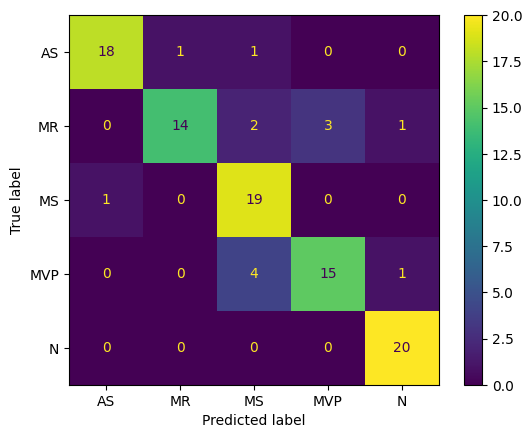

Accuracy : [0.97 0.93 0.92 0.92 0.98] mean:  0.944
Precision : [0.94736842 0.93333333 0.73076923 0.83333333 0.90909091] mean:  0.8707790455158877
Sensitivity : [0.9  0.7  0.95 0.75 1.  ] mean:  0.86
Specificity : [0.9875 0.9875 0.9125 0.9625 0.975 ] mean:  0.9650000000000001
f1_score: [0.92307692 0.8        0.82608696 0.78947368 0.95238095] mean:  0.8582037032380281



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L6.csv_4.h5
4/4 [==============================] - 0s 5ms/step


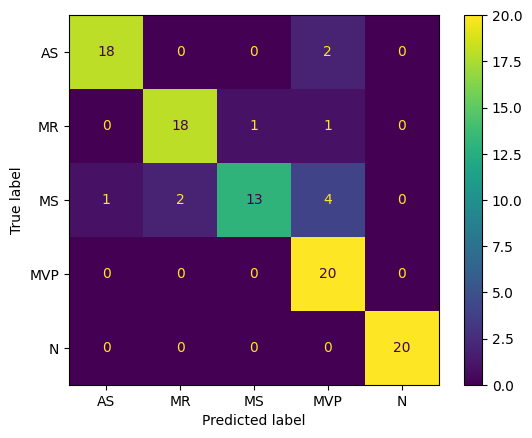

Accuracy : [0.97 0.96 0.92 0.93 1.  ] mean:  0.9560000000000001
Precision : [0.94736842 0.9        0.92857143 0.74074074 1.        ] mean:  0.9033361180729601
Sensitivity : [0.9  0.9  0.65 1.   1.  ] mean:  0.89
Specificity : [0.9875 0.975  0.9875 0.9125 1.    ] mean:  0.9725000000000001
f1_score: [0.92307692 0.9        0.76470588 0.85106383 1.        ] mean:  0.8877693270434197



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L7.csv_4.h5
4/4 [==============================] - 0s 5ms/step


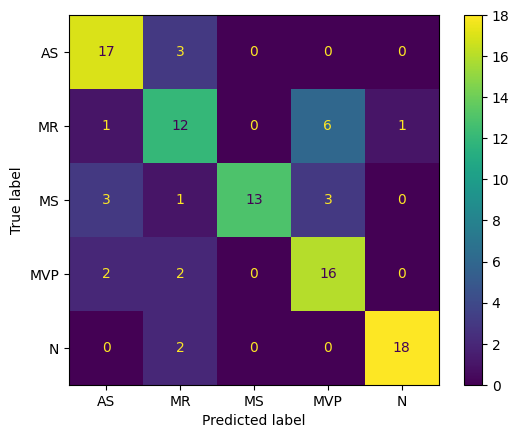

Accuracy : [0.91 0.84 0.93 0.87 0.97] mean:  0.9040000000000001
Precision : [0.73913043 0.6        1.         0.64       0.94736842] mean:  0.785299771167048
Sensitivity : [0.85 0.6  0.65 0.8  0.9 ] mean:  0.76
Specificity : [0.925  0.9    1.     0.8875 0.9875] mean:  0.9400000000000001
f1_score: [0.79069767 0.6        0.78787879 0.71111111 0.92307692] mean:  0.7625528992970854



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L8.csv_4.h5
4/4 [==============================] - 0s 6ms/step


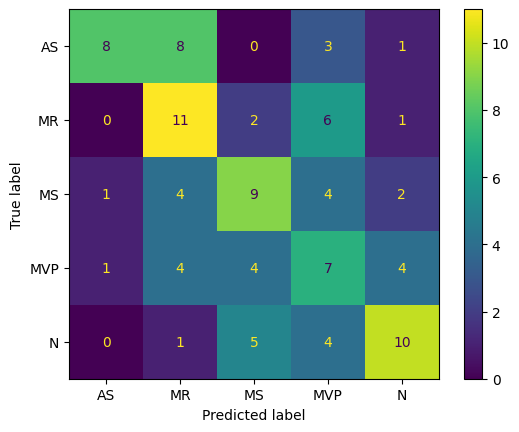

Accuracy : [0.86 0.74 0.78 0.7  0.82] mean:  0.78
Precision : [0.8        0.39285714 0.45       0.29166667 0.55555556] mean:  0.498015873015873
Sensitivity : [0.4  0.55 0.45 0.35 0.5 ] mean:  0.45
Specificity : [0.975  0.7875 0.8625 0.7875 0.9   ] mean:  0.8625
f1_score: [0.53333333 0.45833333 0.45       0.31818182 0.52631579] mean:  0.45723285486443377



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L9.csv_5.h5
4/4 [==============================] - 0s 5ms/step


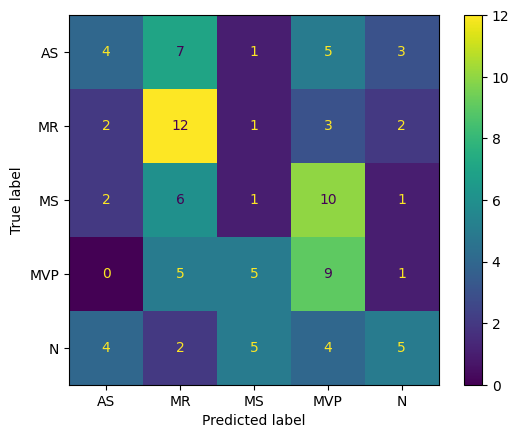

Accuracy : [0.76 0.72 0.69 0.67 0.78] mean:  0.724
Precision : [0.33333333 0.375      0.07692308 0.29032258 0.41666667] mean:  0.2984491315136476
Sensitivity : [0.2  0.6  0.05 0.45 0.25] mean:  0.31
Specificity : [0.9    0.75   0.85   0.725  0.9125] mean:  0.8275
f1_score: [0.25       0.46153846 0.06060606 0.35294118 0.3125    ] mean:  0.28751713972302206



Processing ../modelh5/RNN_FT/best_model/RNN_FT_KFold_data_MfccDwtChromaCqtdb10L10.csv_3.h5
4/4 [==============================] - 0s 5ms/step


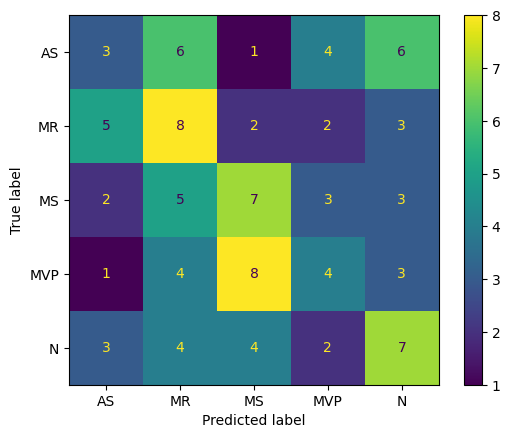

Accuracy : [0.72 0.69 0.72 0.73 0.72] mean:  0.716
Precision : [0.21428571 0.2962963  0.31818182 0.26666667 0.31818182] mean:  0.2827224627224627
Sensitivity : [0.15 0.4  0.35 0.2  0.35] mean:  0.29000000000000004
Specificity : [0.8625 0.7625 0.8125 0.8625 0.8125] mean:  0.8225
f1_score: [0.17647059 0.34042553 0.33333333 0.22857143 0.33333333] mean:  0.2824268430776566



Accuracy All : [0.8400000000000001, 0.8159999999999998, 0.892, 0.968, 0.944, 0.9560000000000001, 0.9040000000000001, 0.78, 0.724, 0.716]
Precision All : [0.5923001949317739, 0.545356926799758, 0.7402255639097743, 0.9209311156679577, 0.8707790455158877, 0.9033361180729601, 0.785299771167048, 0.498015873015873, 0.2984491315136476, 0.2827224627224627]
Sensitivity All : [0.6, 0.54, 0.73, 0.9199999999999999, 0.86, 0.89, 0.76, 0.45, 0.31, 0.29000000000000004]
Specificity All : [0.9, 0.885, 0.9324999999999999, 0.9800000000000001, 0.9650000000000001, 0.9725000000000001, 0.9400000000000001, 0.8625, 0.8275, 0.8225]
f1_score All

In [22]:
testingVHD(a10, 10)